In [1]:
import warnings
warnings.filterwarnings('ignore',category=RuntimeWarning)
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import glob,os,sys
from tqdm.auto import tqdm
import proplot as plot
import json,pickle
import dask.array as da
import gc
from sklearn.decomposition import PCA
sys.path.insert(1, '/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/2020_TC_CRF/dev/freddy0218/')
from tools import derive_var,read_and_proc,preproc_noensemble
from tools.mlr import mlr,proc_mlrfcst,maria_IO,ffs
from tools.preprocess import do_eof,preproc_maria,preproc_haiyan
sys.path.insert(2, '/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/testML/')
import feature_select
from dask.distributed import Client
client = Client(processes=True, threads_per_worker=1,n_workers=2)
%matplotlib inline
plot.rc.update({'figure.facecolor':'w','axes.labelweight':'ultralight',
                'tick.labelweight':'ultralight','gridminor.linestyle':'--','title.weight':'normal','linewidth':0.5})

distributed.diskutils - INFO - Found stale lock file and directory '/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/testML/preproc/Haiyan/dask-worker-space/worker-9pq42hku', purging
distributed.diskutils - INFO - Found stale lock file and directory '/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/testML/preproc/Haiyan/dask-worker-space/worker-81r422s1', purging
/tmp/ipykernel_1838743/1099128259.py:24: ProplotWarning: rc setting 'linewidth' was renamed to 'meta.width' in version 0.8.
  plot.rc.update({'figure.facecolor':'w','axes.labelweight':'ultralight',


In [2]:
def forward_diff(arrayin=None,delta=None,axis=None,LT=1):
    result = []
    if axis==0:
        for i in range(0,arrayin.shape[axis]-LT):
            temp = (arrayin[i+LT,:]-arrayin[i,:])/(LT*delta)
            result.append(temp)
        return np.asarray(result)
    
from sklearn.metrics import r2_score    
class retrieve_cartesian:
    def __init__(self,PCA_dict=None,Af_dict=None,numcomp=[11,11,15],LT=None,forecastPC=None,target='all',suffix=None):
        self.PCA_dict=PCA_dict
        self.numcomp=numcomp
        self.forecastPC = forecastPC
        self.LT = LT
        self.target=target
        self.suffix=suffix
        
    def get_time_diff_terms(self,inputvar=None,LT=None,wantvar=None):
        def _get_time_diff(array=None,timedelta=60*60,LT=None):
            store = []
            for exp in array:
                a = forward_diff(exp,timedelta,0,LT)
                if a.shape[0]>0:
                    azero = np.zeros((LT,exp.shape[-1]))
                    store.append(np.asarray(a))
                    #store.append(np.concatenate((a,azero),axis=0))
                else:
                    continue
                    #store.append(np.zeros((exp.shape[0],exp.shape[-1])))
            return store
        
        storedict = {}
        for wantvarZ,wantvarN in enumerate(wantvar):
            storedict[wantvarN] = _get_time_diff(array=inputvar[wantvarZ],LT=LT)
        return storedict
    
    def _pop_valid_test(self,examplist=None,validindex=None,testindex=None):
        [examplist.pop(i) for i in validindex]
        [examplist.pop(i) for i in testindex]
        return None
        
    def windrates_real(self,uvwheatpath=None,LT=None,category='train',validindex=[1,6],testindex=[2,12]):
        u = [read_and_proc.depickle(path+uvwheatpath+'mem'+str(lime)+self.suffix)['u'] for lime in (range(1,21))].copy()
        v = [read_and_proc.depickle(path+uvwheatpath+'mem'+str(lime)+self.suffix)['v'] for lime in (range(1,21))].copy()
        w = [read_and_proc.depickle(path+uvwheatpath+'mem'+str(lime)+self.suffix)['w'] for lime in (range(1,21))].copy()
        theta = [read_and_proc.depickle(path+uvwheatpath+'mem'+str(lime)+self.suffix)['theta'] for lime in (range(1,21))].copy()
        
        if category=='train':
            popindex = validindex+testindex
            ut = [u[i] for i in range(len(u)) if i not in popindex]
            vt = [v[i] for i in range(len(v)) if i not in popindex]
            wt = [w[i] for i in range(len(w)) if i not in popindex]
            thetat = [theta[i] for i in range(len(theta)) if i not in popindex]
            #self._pop_valid_test(u,validindex,testindex)
            #self._pop_valid_test(v,validindex,testindex)
            #self._pop_valid_test(w,validindex,testindex)
            #self._pop_valid_test(theta,validindex,testindex)
            assert len(ut)==16, 'wrong train-valid-test separation!'
            dtermsT = self.get_time_diff_terms(inputvar=[ut,vt,wt,thetat],LT=LT,wantvar=['u','v','w','theta'])
        elif category=='valid':
            uv = [u[index] for index in validindex]
            vv = [v[index] for index in validindex]
            wv = [w[index] for index in validindex]
            thetav = [theta[index] for index in validindex]
            del u,v,w,theta
            gc.collect()
            dtermsT = self.get_time_diff_terms(inputvar=[uv,vv,wv,thetav],LT=LT,wantvar=['u','v','w','theta'])
        elif category=='test':
            ut = [u[index] for index in testindex]
            vt = [v[index] for index in testindex]
            wt = [w[index] for index in testindex]
            thetat = [theta[index] for index in testindex]            
            del u,v,w,theta
            gc.collect()
            dtermsT = self.get_time_diff_terms(inputvar=[ut,vt,wt,thetat],LT=LT,wantvar=['u','v','w','theta'])            
        
        dudt = np.concatenate([testx for testx in dtermsT['u']],axis=0)
        dvdt = np.concatenate([testx for testx in dtermsT['v']],axis=0)
        dwdt = np.concatenate([testx for testx in dtermsT['w']],axis=0)
        dthdt = np.concatenate([testx for testx in dtermsT['theta']],axis=0)
        del dtermsT
        gc.collect()
        return dudt,dvdt,dwdt,dthdt
    
    def output_reshapeRECON(self,forecast_eig=None):
        if (self.target=='surface') or (self.target=='alluv'):
            testrec_dudt = np.dot(forecast_eig[:,0:self.numcomp[0]],(self.PCA_dict['u'].components_[0:self.numcomp[0]]))#.reshape((91,39,360,167))
            testrec_dvdt = np.dot(forecast_eig[:,self.numcomp[0]:self.numcomp[0]+self.numcomp[1]],(self.PCA_dict['v'].components_[0:self.numcomp[1]]))#.reshape((91,39,360,167))
            return testrec_dudt,testrec_dvdt
        else:
            testrec_dudt = np.dot(forecast_eig[:,0:self.numcomp[0]],(self.PCA_dict['u'].components_[0:self.numcomp[0]]))#.reshape((91,39,360,167))
            testrec_dvdt = np.dot(forecast_eig[:,self.numcomp[0]:self.numcomp[0]+self.numcomp[1]],(self.PCA_dict['v'].components_[0:self.numcomp[1]]))#.reshape((91,39,360,167))
            testrec_dwdt = np.dot(forecast_eig[:,self.numcomp[0]+self.numcomp[1]:self.numcomp[0]+self.numcomp[1]+self.numcomp[2]],(self.PCA_dict['w'].components_[0:self.numcomp[2]]))#.reshape((39,360,167))
            testrec_dthdt = np.dot(forecast_eig[:,self.numcomp[0]+self.numcomp[1]+self.numcomp[2]:],(self.PCA_dict['theta'].components_[0:self.numcomp[3]]))#.reshape((39,360,167))
            return testrec_dudt,testrec_dvdt,testrec_dwdt,testrec_dthdt
        
    def conversion_predictPC(self,yforecast=None,mshpe=[39,360,167]):
        if self.target=='surface':
            t1,t2 = self.output_reshapeRECON(forecast_eig=yforecast)
            return (t1.reshape(t1.shape[0],mshpe[0],mshpe[1],mshpe[2])[:,0,:,:]).reshape(t1.shape[0],mshpe[1]*mshpe[2]),(t2.reshape(t2.shape[0],mshpe[0],mshpe[1],mshpe[2])[:,0,:,:]).reshape(t2.shape[0],mshpe[1]*mshpe[2])
        elif self.target=='alluv':
            t1,t2 = self.output_reshapeRECON(forecast_eig=yforecast)
            return t1,t2
        elif self.target=='all': 
            t1,t2,t3,t4 = self.output_reshapeRECON(forecast_eig=yforecast)
            return t1,t2,t3,t4
        
    def output_r2(self,FFWmodels=None,reducedX=None,realU=None,realV=None,realW=None,realTH=None,case='Haiyan',numoutput=5):
        yf = [models.predict(Xns) for (models,Xns) in zip(FFWmodels[:],reducedX[:])]
        mlr_r2 = []
        for i in (range(numoutput)):#len(yf))):
            if case=='Maria':
                temp1,temp2 = self.conversion_predictPC(yforecast=yf[i],mshpe=[39,360,167])
                mlr_r2.append(r2_score(np.concatenate((realU,realV),axis=0),np.concatenate((temp1,temp2),axis=0)))
            elif case=='Haiyan':
                try:
                    temp1,temp2 = self.conversion_predictPC(yforecast=yf[i],mshpe=[10,360,208])
                    a = r2_score(np.concatenate((realU,realV),axis=0),np.concatenate((temp1,temp2),axis=0))
                    print(a)
                    mlr_r2.append(a)
                except:
                    temp1,temp2,temp3,temp4 = self.conversion_predictPC(yforecast=yf[i],mshpe=[10,360,208])
                    a = r2_score(np.concatenate((realU,realV,realW,realTH),axis=0),np.concatenate((temp1,temp2,temp3,temp4),axis=0))
                    #print(a)
                    mlr_r2.append(a)
            del temp1,temp2
            gc.collect()
        return mlr_r2

In [3]:
path = '/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/'
suffix = '_smooth_preproc_dict1b_g'
a = [read_and_proc.depickle(path+'TCGphy/testML/output/haiyan/processed/uvwheat/'+'mem'+str(lime)+suffix)['u'].shape for lime in tqdm(range(1,21))]
# divide experiments reference
divider = np.asarray([aobj[0] for aobj in a]).cumsum()

haiyan_u = np.concatenate([read_and_proc.depickle(path+'TCGphy/testML/output/haiyan/processed/uvwheat/'+'mem'+str(lime)+suffix)['u'] for lime in tqdm(range(1,21))],axis=0)
haiyan_v = np.concatenate([read_and_proc.depickle(path+'TCGphy/testML/output/haiyan/processed/uvwheat/'+'mem'+str(lime)+suffix)['v'] for lime in tqdm(range(1,21))],axis=0)
haiyan_w = np.concatenate([read_and_proc.depickle(path+'TCGphy/testML/output/haiyan/processed/uvwheat/'+'mem'+str(lime)+suffix)['w'] for lime in tqdm(range(1,21))],axis=0)
haiyan_qv = np.concatenate([read_and_proc.depickle(path+'TCGphy/testML/output/haiyan/processed/uvwheat/'+'mem'+str(lime)+suffix)['qv'] for lime in tqdm(range(1,21))],axis=0)
haiyan_theta = np.concatenate([read_and_proc.depickle(path+'TCGphy/testML/output/haiyan/processed/uvwheat/'+'mem'+str(lime)+suffix)['theta'] for lime in tqdm(range(1,21))],axis=0)
#haiyan_heatsum = np.concatenate([read_and_proc.depickle(path+'TCGphy/testML/output/haiyan/processed/uvwheat/'+'mem'+str(lime)+suffix)['heatsum'] for lime in tqdm(range(1,21))],axis=0)
#haiyan_hdia = np.concatenate([read_and_proc.depickle(path+'TCGphy/testML/output/haiyan/processed/uvwheat/'+'mem'+str(lime)+suffix)['hdia'] for lime in tqdm(range(1,21))],axis=0)
haiyan_rad = np.concatenate([read_and_proc.depickle(path+'TCGphy/testML/output/haiyan/processed/uvwheat/'+'mem'+str(lime)+suffix)['rad'] for lime in tqdm(range(1,21))],axis=0)
#haiyan_ir = np.concatenate([read_and_proc.depickle(path+'TCGphy/testML/output/haiyan/processed/uvwheat/'+'mem'+str(lime)+suffix)['ir'] for lime in tqdm(range(1,21))],axis=0)

folderpath='/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/testML/output/haiyan/processed/'
PCAdict,dict2 = read_and_proc.depickle(folderpath+'pca/PCA'+'_'+'dict1_g'),read_and_proc.depickle(folderpath+'pca/PCA'+'_'+'dict2_g') #dict1: u,v,w,theta,hdia,rad; dict2:qv,ir
PCAdict['qv'] = (dict2['qv'])
PCAdict['ir'] = (dict2['ir'])

dims = ['sample','flatarray']
coords = dict(sample=np.linspace(0,haiyan_u.shape[0]-1,haiyan_u.shape[0]),flatarray=np.linspace(0,haiyan_u.shape[1]-1,haiyan_u.shape[1]))

ds = xr.Dataset(coords=coords)
haiyan_data=preproc_haiyan.build_a_xarray_dataset(ds=ds,varname=['u','v','w','theta','qv','rad'],\
                                   varfile=[haiyan_u,haiyan_v,haiyan_w,haiyan_theta,haiyan_qv,haiyan_rad],dims=dims,coords=coords)
del haiyan_u,haiyan_v,haiyan_w,haiyan_theta,dict2
gc.collect()
#,'qv'],\

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

218

In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectorMixin
from sklearn.metrics import r2_score
from sklearn.base import BaseEstimator, MetaEstimatorMixin, clone
from sklearn.model_selection import cross_val_score

def flatten(xss):
    return [x for xs in xss for x in xs]

class random_FFT:
    def __init__(self,validindex=None,testindex=None,varnum=None,LT=None):
        self.validindex = validindex
        self.testindex = testindex
        self.varnum = varnum
        self.LT = LT
        
    def output_realdterms(self,category='train',varnum=None,LT=24):
        if self.varnum==2:
            a,b,_,_ = retrieve_cartesian(PCA_dict=None,Af_dict=haiyan_data,numcomp=None,LT=self.LT,forecastPC=None,\
                                         target='all',suffix=suffix).windrates_real(uvwheatpath='TCGphy/testML/output/haiyan/processed/uvwheat/',\
                                                                                    LT=LT,category=category,validindex=self.validindex,testindex=self.testindex)
            return a,b
        elif self.varnum==4:
            a,b,c,d = retrieve_cartesian(PCA_dict=None,Af_dict=haiyan_data,numcomp=None,LT=self.LT,forecastPC=None,\
                                         target='all',suffix=suffix).windrates_real(uvwheatpath='TCGphy/testML/output/haiyan/processed/uvwheat/',\
                                                                                    LT=LT,category=category,validindex=self.validindex,testindex=self.testindex)     
            return a,b,c,d
        
    def separate_realwinds(self,vertshape=10):
        realdu,realdv,realdw,realdtheta = self.output_realdterms(category='train',varnum=self.varnum,LT=self.LT)
        realdu_valid,realdv_valid,realdw_valid,realdtheta_valid = self.output_realdterms(category='valid',varnum=self.varnum,LT=self.LT)
        realdu_test,realdv_test,realdw_test,realdtheta_test = self.output_realdterms(category='test',varnum=self.varnum,LT=self.LT)
        ################################################################################################################################################
        # Surface winds
        ################################################################################################################################################
        radsize = int(realdu.shape[1]/vertshape/360)
        realsurfu,realsurfv = realdu.reshape(realdu.shape[0],vertshape,360,radsize)[:,0,:,:].reshape(realdu.shape[0],360*radsize),realdv.reshape(realdv.shape[0],vertshape,360,radsize)[:,0,:,:].reshape(realdu.shape[0],360*radsize)
        realsurfu_valid,realsurfv_valid = realdu_valid.reshape(realdu_valid.shape[0],vertshape,360,radsize)[:,0,:,:].reshape(realdu_valid.shape[0],360*radsize),realdv_valid.reshape(realdv_valid.shape[0],vertshape,360,radsize)[:,0,:,:].reshape(realdu_valid.shape[0],360*radsize)
        realsurfu_test,realsurfv_test = realdu_test.reshape(realdu_test.shape[0],vertshape,360,radsize)[:,0,:,:].reshape(realdu_test.shape[0],360*radsize),realdv_test.reshape(realdv_test.shape[0],vertshape,360,radsize)[:,0,:,:].reshape(realdu_test.shape[0],360*radsize)
        del realdu,realdv,realdw,realdtheta,realdu_valid,realdv_valid,realdw_valid,realdtheta_valid,realdu_test,realdv_test,realdw_test,realdtheta_test
        gc.collect()
        return {'u':realsurfu,'v':realsurfv},{'u':realsurfu_valid,'v':realsurfv_valid},{'u':realsurfu_test,'v':realsurfv_test}
    
    def separate_realall(self,vertshape=10):
        realdu,realdv,realdw,realdtheta = self.output_realdterms(category='train',varnum=self.varnum,LT=self.LT)
        realdu_valid,realdv_valid,realdw_valid,realdtheta_valid = self.output_realdterms(category='valid',varnum=self.varnum,LT=self.LT)
        realdu_test,realdv_test,realdw_test,realdtheta_test = self.output_realdterms(category='test',varnum=self.varnum,LT=self.LT)
        return {'u':realdu,'v':realdv,'w':realdw,'theta':realdtheta},{'u':realdu_valid,'v':realdv_valid,'w':realdw_valid,'theta':realdtheta_valid},{'u':realdu_test,'v':realdv_test,'w':realdw_test,'theta':realdtheta_test}
    
    def preproc_INOUT(self,yall=None,Xtrain=None,expTYPE='dtthuvw',nummem=[50,38,91,8],optimizeto='train'):
        # Initiate model [54,26,50,7
        linreg = LinearRegression()
        if optimizeto=='train':
            ytrain = [yobj[0] for yobj in yall]
        elif optimizeto=='valid':
            ytrain = [yobj[1] for yobj in yall]
        mlrIN,mlrOUT = mlr.SimpleIOhandler(LT=self.LT,auxIN=None).transform(Xtrain[expTYPE],ytrain)
        return mlrIN,mlrOUT,linreg
    
    def do_seq_FS(self,data=haiyan_data,PCAdict=None,yall=None,Xtrain=None,Xvalid=None,expTYPE='dtthuvw',\
                  findextra=40,cv=7,nummem=[50,38,91,8],holdmem=None,optimizeto='train'):
        model,reducedX,new_feature = [],[],[]
        if optimizeto=='train':
            mlrIN,mlrOUT,linreg = self.preproc_INOUT(yall,Xtrain,expTYPE,nummem,'train')
        elif optimizeto=='valid':
            mlrIN,mlrOUT,linreg = self.preproc_INOUT(yall,Xvalid,expTYPE,nummem,'valid')
            mlrIN_train,mlrOUT_train,_ = self.preproc_INOUT(yall,Xtrain,expTYPE,nummem,'train')
        #holdmem = holdmem
        for i in tqdm(range(findextra)):#np.asarray(mlrIN).shape[1]-20)):
            seq_temp = forwardfeatureadder(linreg,1,cv,4,holdmem,\
                                           PCAdict,haiyan_data,nummem,self.LT,'all',None,None,[10,360,208],'No').fit(np.asarray(mlrIN),mlrOUT)
            holdmem.append(seq_temp.new_feature)
            new_feature.append(seq_temp.new_feature)
            Xn = seq_temp.transform(np.asarray(mlrIN_train)) #Remove unimportant features
            ridge_reduced = LinearRegression().fit(Xn,mlrOUT_train) #Train model with reduced input
            model.append(ridge_reduced)
            reducedX.append(Xn)
        return model,reducedX,new_feature
    
    def do_seq_FS_r2(self,data=haiyan_data,PCAdict=None,yall=None,Xtrain=None,Xvalid=None,expTYPE='dtthuvw',\
                  findextra=40,cv=7,nummem=[50,38,91,8],holdmem=None,optimizeto='train',validREAL=None):
        model,reducedX,new_feature = [],[],[]
        if optimizeto=='train':
            mlrIN,mlrOUT,linreg = self.preproc_INOUT(yall,Xtrain,expTYPE,nummem,'train')
        elif optimizeto=='valid':
            mlrIN,mlrOUT,linreg = self.preproc_INOUT(yall,Xvalid,expTYPE,nummem,'valid')
            mlrIN_train,mlrOUT_train,_ = self.preproc_INOUT(yall,Xtrain,expTYPE,nummem,'train')
        # Define basic settings
        #n_features = Xtrain[expTYPE].shape[1]
        #current_mask = np.zeros(shape=n_features,dtype=bool)
        #for index in holdmem:
        #    current_mask[index] = True
        #Xn = [mlrIN_trainobj[current_mask] for mlrIN_trainobj in mlrIN_train]

        for i in tqdm(range(findextra)):#np.asarray(mlrIN).shape[1]-20)):
            seq_temp = forwardfeatureadder(linreg,1,cv,4,holdmem,\
                                           PCAdict,haiyan_data,nummem,self.LT,'all',validREAL,[10,360,208],'Yes',mlrIN_train,mlrOUT_train).fit(np.asarray(mlrIN),mlrOUT)
            holdmem.append(seq_temp.new_feature)
            new_feature.append(seq_temp.new_feature)
            Xn = seq_temp.transform(np.asarray(mlrIN_train)) #Remove unimportant features
            ridge_reduced = LinearRegression().fit(Xn,mlrOUT_train) #Train model with reduced input
            model.append(ridge_reduced)
            reducedX.append(Xn)
        return model,reducedX,new_feature
    
class forwardfeatureadder(BaseEstimator,SelectorMixin,MetaEstimatorMixin):
    """Transformer to add feature at a sequential order
    Parameters:
    estimator: Regression model
    n_features_to_select: number of features to add to the model
    cv: how many folds would we want during cross-validation
    n_jobs: Parallelization
    startfeatures: Features we would like to include in the model without cross-validation [we do this to accentuate the role of heating]
    
    Output:
    self instance
    """
    def __init__(self,estimator,n_features_to_select=None,cv=5,n_jobs=None,startfeatures=None,PCAdict=None,Afdict=None,numcomp=None,LT=None,optigoal='all',realWRF=None,mshpe=[10,360,208],r2_based='Yes',\
                Xtrain=None,ytrain=None):
        self.estimator = estimator
        self.n_features_to_select = n_features_to_select
        self.cv = cv
        self.n_jobs = n_jobs
        self.startfeatures = startfeatures
        self.PCAdict = PCAdict
        self.Afdict = Afdict
        self.numcomp = numcomp
        self.LT = LT
        self.optigoal = optigoal
        self.realWRF = realWRF
        self.mshpe = mshpe
        self.r2_based=r2_based
        self.Xtrain=Xtrain
        self.ytrain=ytrain
    
    def get_real_winds(self):
        temp1,temp2,temp3,temp4 = proc_mlrfcst.retrieve_cartesian(PCA_dict=self.PCAdict,Af_dict=self.Afdict,numcomp=self.numcomp,LT=self.LT,
                            forecastPC=None).windrates_real(LT=self.LT)
        return temp1,temp2,temp3,temp4
    
    def output_reshapeRECON(self,forecast_eig=None):
        if (self.optigoal=='surface') or (self.optigoal=='alluv'):
            testrec_dudt = np.dot(forecast_eig[:,0:self.numcomp[0]],(self.PCAdict['u'].components_[0:self.numcomp[0]]))#.reshape((91,39,360,167))
            testrec_dvdt = np.dot(forecast_eig[:,self.numcomp[0]:self.numcomp[0]+self.numcomp[1]],(self.PCAdict['v'].components_[0:self.numcomp[1]]))#.reshape((91,39,360,167))
            return testrec_dudt,testrec_dvdt
        else:
            testrec_dudt = np.dot(forecast_eig[:,0:self.numcomp[0]],(self.PCAdict['u'].components_[0:self.numcomp[0]]))#.reshape((91,39,360,167))
            testrec_dvdt = np.dot(forecast_eig[:,self.numcomp[0]:self.numcomp[0]+self.numcomp[1]],(self.PCAdict['v'].components_[0:self.numcomp[1]]))#.reshape((91,39,360,167))
            testrec_dwdt = np.dot(forecast_eig[:,self.numcomp[0]+self.numcomp[1]:self.numcomp[0]+self.numcomp[1]+self.numcomp[2]],(self.PCAdict['w'].components_[0:self.numcomp[2]]))#.reshape((39,360,167))
            testrec_dthdt = np.dot(forecast_eig[:,self.numcomp[0]+self.numcomp[1]+self.numcomp[2]:],(self.PCAdict['theta'].components_[0:self.numcomp[3]]))#.reshape((39,360,167))
            return testrec_dudt,testrec_dvdt,testrec_dwdt,testrec_dthdt
        
    def conversion_predictPC(self,yforecast=None,mshpe=[39,360,167]):
        if self.optigoal=='surface':
            t1,t2 = self.output_reshapeRECON(forecast_eig=yforecast)
            return (t1.reshape(t1.shape[0],mshpe[0],mshpe[1],mshpe[2])[:,0,:,:]).reshape(t1.shape[0],mshpe[1]*mshpe[2]),(t2.reshape(t2.shape[0],mshpe[0],mshpe[1],mshpe[2])[:,0,:,:]).reshape(t2.shape[0],mshpe[1]*mshpe[2])
        elif self.optigoal=='alluv':
            t1,t2 = self.output_reshapeRECON(forecast_eig=yforecast)
            return t1,t2
        elif self.optigoal=='all': 
            t1,t2,t3,t4 = self.output_reshapeRECON(forecast_eig=yforecast)
            return t1,t2,t3,t4
    
    def fit(self, X,y=None):
        """Learn features to select from X.
        X (n_samples,n_features): Training vectors
        Y (n_samples): Target values
        """
        # Define basic settings
        n_features = X.shape[1]
        current_mask = np.zeros(shape=n_features,dtype=bool)
        for index in self.startfeatures:
            current_mask[index] = True
        n_iteractions = self.n_features_to_select
        
        # Do forward selection
        addinput,r2 = [],[]
        clone_estimator = clone(self.estimator)
        for _ in range(n_iteractions):
            #new_feature_idx,r2t = self.get_best_new_feature_R2based(clone_estimator,X,y,current_mask)
            if self.r2_based=='No':
                new_feature_idx = self.get_best_new_feature(clone_estimator,X,y,current_mask)
            else:
                new_feature_idx,_ = self.get_best_new_feature_R2based(clone_estimator,X,y,current_mask,self.Xtrain,self.ytrain)
            #r2.append(r2t)
            current_mask[new_feature_idx] = True
            addinput.append(current_mask)
        
        self.support_ = current_mask
        self.new_feature = new_feature_idx
        self.r2 = r2
        return self
    
    def get_best_new_feature(self,estimator,X,y,current_mask):
        candidate_feature_indices = np.flatnonzero(~current_mask)
        scores={}
        for feature_idx in candidate_feature_indices:
            candidate_mask = current_mask.copy()
            candidate_mask[feature_idx] = True
            
            # Add a new feature
            X_new = X[:,candidate_mask]
            # Improvement
            scores[feature_idx] = cross_val_score(estimator,X_new,y,cv=self.cv,scoring=None,n_jobs=self.n_jobs).mean()
        return max(scores,key=lambda feature_idx: scores[feature_idx])
    
    #--------------------------------------------------------------
    # To do -> Add featureselector based on r2
    # Candidate mask -> Xnew
    # fit linear model with (Xnew,y)
    # {output r2 term [time consideration => target: surface u/v]}...repeat for all u/v/w/theta members
    # get component index that results in best r2 score
    # --------[[Exit loops when r2 reaches 0.75?]]-----------------
    # add to mask during fitting 
    #---------------------------------------------------------------------------------------------------
    def get_best_new_feature_R2based(self,estimator,X,y,current_mask,XtrainIN,ytrainIN):             
        candidate_feature_indices = np.flatnonzero(~current_mask)
        scores={}
        for feature_idx in candidate_feature_indices:
            candidate_mask = current_mask.copy()
            candidate_mask[feature_idx] = True
            # Add a new feature
            X_new = X[:,candidate_mask]
            Xtrain_new = [XtrainINobj[candidate_mask] for XtrainINobj in XtrainIN]
            fittedmodel = LinearRegression().fit(Xtrain_new,ytrainIN)
            # Forecast y_valid with trained model
            y_forecast = fittedmodel.predict(X_new)
            #################################################################################################################################################################################################################
            # Forecast winds
            #################################################################################################################################################################################################################
            if self.optigoal=='surface':
                #teMP1,teMP2 = self.convert_forecast_winds(y_forecast)
                #teMP1s,teMP2s = (teMP1.reshape(teMP1.shape[0],39,360,167)[:,0,:,:]).reshape(teMP1.shape[0],360*167),(teMP2.reshape(teMP2.shape[0],39,360,167)[:,0,:,:]).reshape(teMP2.shape[0],360*167)
                #del teMP1,teMP2
                #gc.collect()
                #scores[feature_idx] = r2_score(np.concatenate((self.Xsurf,self.Ysurf),axis=0),np.concatenate((teMP1s,teMP2s),axis=0))
                print("Can't do surface wind R2 yet")
                break
            else:
                teMP1,teMP2,teMP3,teMP4 = self.conversion_predictPC(yforecast=y_forecast,mshpe=self.mshpe)                
                scores[feature_idx] = r2_score(np.concatenate((self.realWRF[0],self.realWRF[1],self.realWRF[2],self.realWRF[3]),axis=0),np.concatenate((teMP1,teMP2,teMP3,teMP4),axis=0))
        return max(scores,key=lambda feature_idx: scores[feature_idx]),max(scores.values())
    
    def _get_support_mask(self):
        return self.support_

In [5]:
folderpath='/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/testML/output/haiyan/processed/'
def _get_exp_name(splitnum=None,folder=2):
    return sorted(glob.glob(folderpath+'pca/X/random/'+str(folder)+'/Xtrain*'))[splitnum][:-7].split('/')[-1][6:],sorted(glob.glob(folderpath+'pca/X/random/'+str(folder)+'/Xtrain*'))[splitnum][:-7].split('/')[-1][6:].split('_')

def real_random(index=None,folder=2):
    toextract = _get_exp_name(index,folder)[0]
    # X
    Xtestpath,Xtrainpath,Xvalidpath = sorted(glob.glob(folderpath+'pca/X/random/'+str(folder)+'/*'+str(toextract)+'*'))
    Xtest,Xtrain,Xvalid = [read_and_proc.depickle(obj) for obj in[Xtestpath,Xtrainpath,Xvalidpath]]
    # y
    yallpath = sorted(glob.glob(folderpath+'pca/y/random/'+str(folder)+'/*'+str(toextract)+'*'))
    yall = read_and_proc.depickle(yallpath[0])
    return Xtest,Xtrain,Xvalid,yall

#### Random

In [6]:
Xtest,Xtrain,Xvalid = [],[],[]
yall = []

for i in tqdm(range(9,18)):
    temp1,temp2,temp3,temp4 = real_random(i,3)
    Xtest.append(temp1)
    Xtrain.append(temp2)
    Xvalid.append(temp3)
    yall.append(temp4)

  0%|          | 0/9 [00:00<?, ?it/s]

In [7]:
[_get_exp_name(i,3)[0] for i in range(9)]#[3,5]

['10_18_9_14',
 '10_2_19_12',
 '11_7_17_1',
 '11_8_18_13',
 '12_14_7_15',
 '12_4_14_16',
 '12_4_2_16',
 '14_10_6_4',
 '14_10_9_13']

In [ ]:
read_and_proc.depickle(sorted(glob.glob('/scratch/itam/temp_store/r2/FFWmodels_cross7_

In [ ]:
read_and_proc.depickle(sorted(glob.glob('/scratch/itam/temp_store/r2/FFWmodels_cross7_valid_r2_4_624_11_7_17_1

In [9]:
train_realUV,valid_realUV,test_realUV = [],[],[]
for i in tqdm([2,4]):#range(1)):
    tempindex = _get_exp_name(i,3)[1]
    validindex,testindex = [int(tempindex[0]),int(tempindex[1])],[int(tempindex[2]),int(tempindex[3])]
    obj1,obj2,obj3 = random_FFT(validindex,testindex,4,24).separate_realall(vertshape=10)
    train_realUV.append(obj1)
    valid_realUV.append(obj2)
    test_realUV.append(obj3)
del obj1,obj2,obj3
gc.collect()

  0%|          | 0/2 [00:00<?, ?it/s]

distributed.nanny - WARNING - Worker process still alive after 3 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 3 seconds, killing


21

In [8]:
lti=24
read_and_proc.save_to_pickle('/scratch/itam/temp_store/realtrain'+str(lti)+'_17_33',train_realUV,'PICKLE')
read_and_proc.save_to_pickle('/scratch/itam/temp_store/realvalid'+str(lti)+'_17_33',valid_realUV,'PICKLE')
read_and_proc.save_to_pickle('/scratch/itam/temp_store/realtest'+str(lti)+'_17_33',test_realUV,'PICKLE')

In [7]:
train_realUV = read_and_proc.depickle('/scratch/itam/temp_store/realtrain24_9_17')
valid_realUV = read_and_proc.depickle('/scratch/itam/temp_store/realvalid24_9_17')
test_realUV = read_and_proc.depickle('/scratch/itam/temp_store/realtest24_9_17')

#### FFS

In [ ]:
INPUT,_,_ = ffs.random_FFT(None,None,4,24).preproc_INOUT(yall=yall[0],Xtrain=Xtrain[0],expTYPE='dtthuvwqv',nummem=[50,38,91,8])
del INPUT
gc.collect()

distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker


In [14]:
import importlib
importlib.reload(ffs)

<module 'tools.mlr.ffs' from '/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/2020_TC_CRF/dev/freddy0218/tools/mlr/ffs.py'>

In [8]:
lti=24
model_FFW,reducedX_FFW,newfeature_FFW = [],[],[]
for i in tqdm([5,7]):#range(1)):#9)):
    indextofilename,tempindex = _get_exp_name(i,3)
    validindex,testindex = [int(tempindex[0]),int(tempindex[1])],[int(tempindex[2]),int(tempindex[3])]
    #obj1,obj2,obj3 = ffs.random_FFT(validindex,testindex,4,24).do_seq_FS(data=haiyan_data,PCAdict=PCAdict,yall=yall[i],Xtrain=Xtrain[i],Xvalid=Xvalid[i],expTYPE='dtthuvwqv',findextra=10,cv=7,nummem=[50,38,91,8],
    #                                                                holdmem=[297, 298, 299, 300, 301, 302, 303, 304, 305, 306],optimizeto='valid')
    obj1,obj2,obj3 = random_FFT(validindex,testindex,4,24).do_seq_FS_r2(data=haiyan_data,PCAdict=PCAdict,yall=yall[i],Xtrain=Xtrain[i],Xvalid=Xvalid[i],expTYPE='dtthuvwqv',findextra=10,
                                                                           cv=7,nummem=[50,38,91,8],holdmem=[297, 298, 299, 300, 301, 302, 303, 304, 305, 306],optimizeto='valid',\
                                                                           validREAL=[valid_realUV[i]['u'],valid_realUV[i]['v'],valid_realUV[i]['w'],valid_realUV[i]['theta']])
    dicT = {'model':obj1,'reducedX':obj2,'newfeature':obj3}
    read_and_proc.save_to_pickle('/scratch/itam/temp_store/FFWmodels_cross7_valid_r2_9_17_'+str(lti)+'_'+str(indextofilename),dicT,'PICKLE')
    del dicT,obj1,obj2,obj3
    #gc.collect()
    #model_FFW.append(obj1)
    #reducedX_FFW.append(obj2)
    #newfeature_FFW.append(obj3)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

#### R2

In [19]:
_get_exp_name(0,3)[0]

'10_18_9_14'

In [16]:
expINDEX = 7
test = [read_and_proc.depickle(sorted(glob.glob('/scratch/itam/temp_store/FFWmodels_cross7_valid_0_9*'))[expINDEX]) for expINDEX in range(9)]

In [6]:
def feature_importance_from_mlr(MODEL=None,smallX=None):
    def _get_feature_importance(WEIGHTx=None,smallXx=None):
        return np.nanmean(np.asarray([temp*smallXx for temp in WEIGHTx]),axis=1)
    weight = MODEL.coef_
    #WEIGHTZ = np.zeros_like(weight)
    return np.asarray([_get_feature_importance(weight[:,weightz],smallX[:,weightz]) for weightz in range(smallX.shape[1])])

In [20]:
len(test)

9

In [19]:
ind = 0
lisTT = test
feature_importance_from_mlr(MODEL=lisTT[0]['model'][0],smallX=lisTT[0]['reducedX'][0])[1,:]

array([ 6.00741312e-05,  5.35714367e-05,  1.78015223e-04,  2.11937956e-04,
       -8.81944772e-05, -3.72435483e-05, -7.29486539e-06, -1.83684903e-05,
       -6.42352262e-05, -1.49020351e-04,  1.14511626e-04,  5.72745347e-05,
       -9.03866988e-05,  4.60605982e-05, -1.87121136e-05, -2.06110995e-05,
        2.96549763e-05,  8.41806286e-05, -2.51539862e-05, -3.78730898e-06,
        7.74553155e-06,  2.58541815e-05, -1.54002283e-05,  6.31865656e-05,
        1.86979547e-05, -2.10366296e-05,  5.07851967e-06, -2.93808733e-05,
       -4.10921178e-06,  2.18668049e-06, -5.13540239e-05, -7.31386111e-06,
        9.84827544e-06, -2.03277540e-05, -2.57294827e-05, -6.95143813e-06,
       -4.37009829e-05,  2.97950624e-05,  2.90585397e-05,  1.46871276e-05,
        6.50403249e-06,  1.53159150e-06,  3.60670396e-05, -2.31543711e-05,
        9.17897815e-06,  1.12906961e-05,  1.23261966e-05,  3.17054406e-06,
        3.55805796e-05,  1.59332239e-05,  2.74910732e-04,  2.60396733e-04,
       -4.25704450e-05,  

In [98]:
len(lisTT[0]['reducedX'])

10

In [64]:
ans = [feature_importance_from_mlr(MODEL=lisTT[0]['model'][i],smallX=lisTT[0]['reducedX'][i])[i+0,:] for i in range(9)]

In [99]:
i=0
#[i for i in range(4)]
ans = [feature_importance_from_mlr(MODEL=lisTT[0]['model'][i],smallX=lisTT[0]['reducedX'][i]) for i in range(9)]

In [136]:
def out_anschoice(modelchoice=None,ind=None):
    return modelchoice[ind+1]
def get_ans(modeliter=None):
    ans = [feature_importance_from_mlr(MODEL=lisTT[modeliter]['model'][i],smallX=lisTT[modeliter]['reducedX'][i]) for i in range(9)]
    store = []
    for i in range(9):
        store.append([out_anschoice(ans[index],i+index).flatten() for index in range(9)])    
    return [np.abs(flatten(store[i])) for i in range(9)]
    
allans = [get_ans(i) for i in range(9)]  

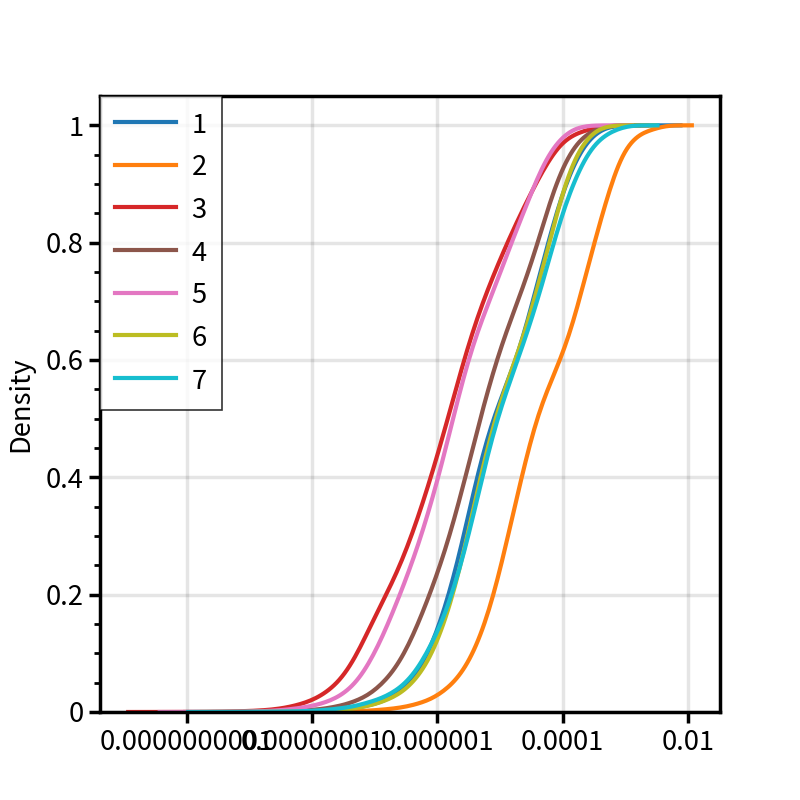

In [141]:
colors=plt.cm.tab10(np.linspace(0, 1, 7))#['k','r','b','g','chocolate','magenta','hotpink']
for i in range(7):
    sns.kdeplot(flatten([allans[index][i] for index in range(9)]),color=colors[i],label=i+1,log_scale=True,cumulative=True)
plt.legend(loc=2)
plt.show()

In [27]:
expname = [_get_exp_name(i,3)[0] for i in range(9)]
test = [read_and_proc.depickle(sorted(glob.glob('/scratch/itam/temp_store/r2/*'+expname[expINDEX]+'*'))[0]) for expINDEX in range(9)]
#test = [read_and_proc.depickle(sorted(glob.glob('/scratch/itam/temp_store/FFWmodels_cross7_valid_0_9*'))[expINDEX]) for expINDEX in range(9)]
#test2 = [read_and_proc.depickle(sorted(glob.glob('/scratch/itam/temp_store/FFWmodels_cross7_valid_9_17*'))[expINDEX]) for expINDEX in range(8)]
lisTT = test#+test2
def produce_list(modellist=None,ind=None):
    #def __producelist__(ind):
    #    return feature_importance_from_mlr(MODEL=lisTT[ind]['model'][0],smallX=lisTT[ind]['reducedX'][0])[ind+1,:]
    store = []
    for i in range(9):
        modeltemp,smallxtemp = modellist[i]['model'],modellist[i]['reducedX']
        print(feature_importance_from_mlr(MODEL=modeltemp[ind],smallX=smallxtemp[ind]).shape)
        #store.append(feature_importance_from_mlr(MODEL=modeltemp[ind],smallX=smallxtemp[ind])[ind+1,:])
    return np.abs(flatten(store))
        
    #return [np.nanpercentile(feature_importance_from_mlr(MODEL=lisTT[i]['model'][0],smallX=lisTT[ind]['reducedX'][0])[ind+1,:].flatten(),99)-np.nanpercentile(feature_importance_from_mlr(MODEL=lisTT[i]['model'][0],\
    #smallX=lisTT[i]['reducedX'][0])[ind+1,:].flatten(),1) for i in range(len(lisTT))]
items = [produce_list(lisTT,ind) for ind in range(9)]

(11, 187)
(11, 187)
(11, 187)
(11, 187)
(11, 187)
(11, 187)
(11, 187)
(11, 187)
(11, 187)
(12, 187)
(12, 187)
(12, 187)
(12, 187)
(12, 187)
(12, 187)
(12, 187)
(12, 187)
(12, 187)
(13, 187)
(13, 187)
(13, 187)
(13, 187)
(13, 187)
(13, 187)
(13, 187)
(13, 187)
(13, 187)
(14, 187)
(14, 187)
(14, 187)
(14, 187)
(14, 187)
(14, 187)
(14, 187)
(14, 187)
(14, 187)
(15, 187)
(15, 187)
(15, 187)
(15, 187)
(15, 187)
(15, 187)
(15, 187)
(15, 187)
(15, 187)
(16, 187)
(16, 187)
(16, 187)
(16, 187)
(16, 187)
(16, 187)
(16, 187)
(16, 187)
(16, 187)
(17, 187)
(17, 187)
(17, 187)
(17, 187)
(17, 187)
(17, 187)
(17, 187)
(17, 187)
(17, 187)
(18, 187)
(18, 187)
(18, 187)
(18, 187)
(18, 187)
(18, 187)
(18, 187)
(18, 187)
(18, 187)
(19, 187)
(19, 187)
(19, 187)
(19, 187)
(19, 187)
(19, 187)
(19, 187)
(19, 187)
(19, 187)


/tmp/ipykernel_1838743/1876794390.py:2: ProplotWarning: rc setting 'linewidth' was renamed to 'meta.width' in version 0.8.
  plot.rc.update({'axes.labelweight':'normal','tick.labelweight':'normal','figure.facecolor':'w','title.color':'k','fontname': 'Source Sans Pro', 'fontsize': 11,'linewidth':1.25})


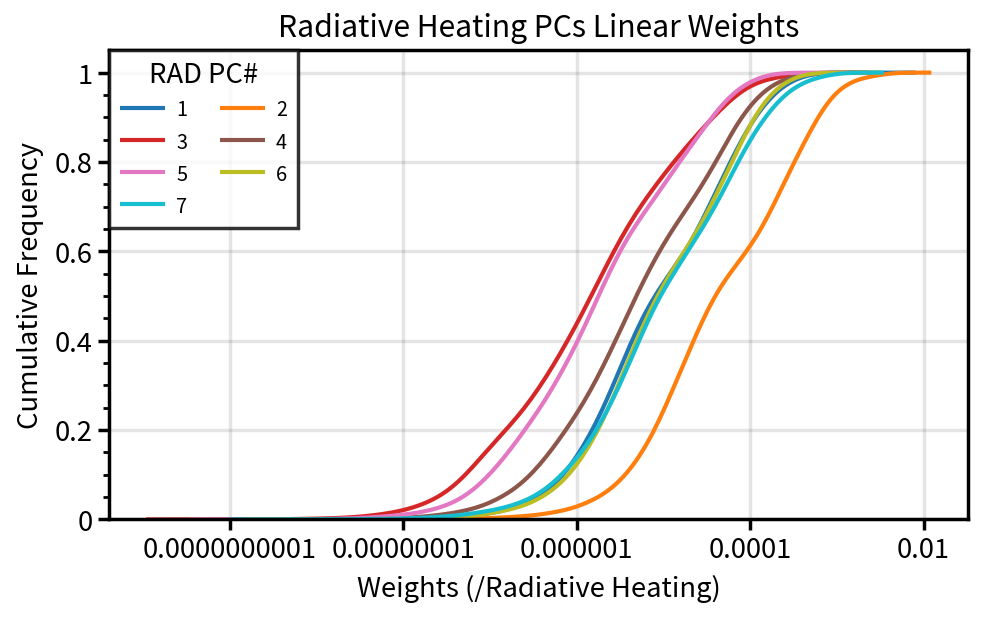

In [144]:
plot.rc.metacolor = 'k'
plot.rc.update({'axes.labelweight':'normal','tick.labelweight':'normal','figure.facecolor':'w','title.color':'k','fontname': 'Source Sans Pro', 'fontsize': 11,'linewidth':1.25})
plot.rc.axesfacecolor = 'w'

colors=plt.cm.tab10(np.linspace(0, 1, 7))
fig,axs = plot.subplots(ncols=1,nrows=1,axwidth=4.295,refaspect=1.831)
for i in range(7):
    sns.kdeplot(flatten([allans[index][i] for index in range(9)]),color=colors[i],label=i+1,log_scale=True,cumulative=True)
axs.legend(loc='ul',prop={'size':8},ncols=2,title='RAD PC#')
axs[0].format(xlabel=r'Weights (/Radiative Heating)',ylabel='Cumulative Frequency',title='Radiative Heating PCs Linear Weights')
#plt.savefig('../../figures/0406/new/RAD_0_9_weights.png',dpi=300)
plt.show()

/tmp/ipykernel_1838743/2762092794.py:2: ProplotWarning: rc setting 'linewidth' was renamed to 'meta.width' in version 0.8.
  plot.rc.update({'axes.labelweight':'normal','tick.labelweight':'normal','figure.facecolor':'w','title.color':'k','fontname': 'Source Sans Pro', 'fontsize': 11,'linewidth':1.25})


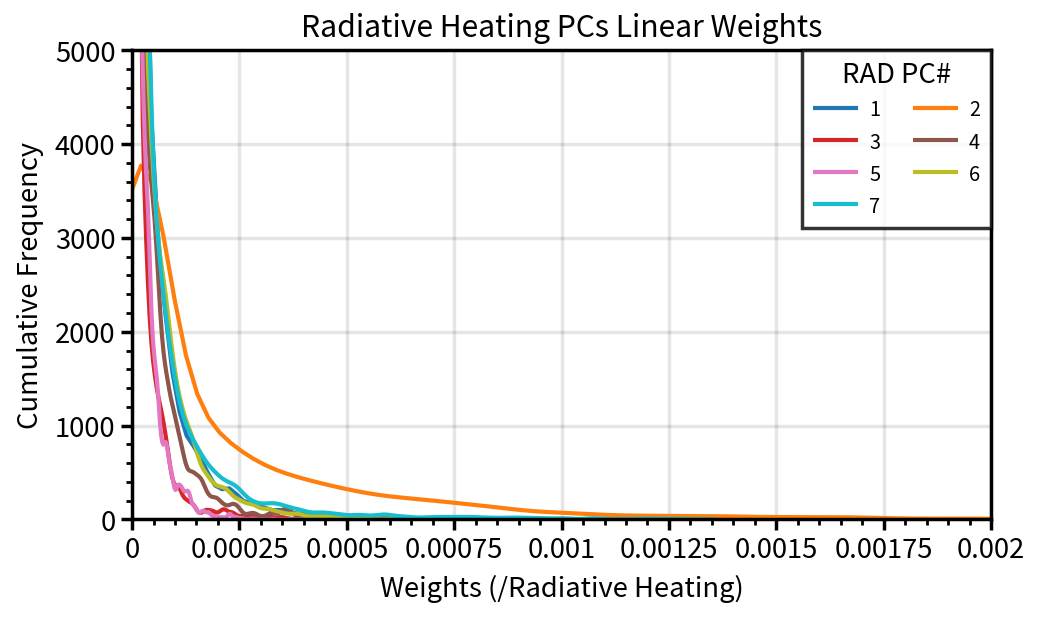

In [158]:
plot.rc.metacolor = 'k'
plot.rc.update({'axes.labelweight':'normal','tick.labelweight':'normal','figure.facecolor':'w','title.color':'k','fontname': 'Source Sans Pro', 'fontsize': 11,'linewidth':1.25})
plot.rc.axesfacecolor = 'w'

colors=plt.cm.tab10(np.linspace(0, 1, 7))
fig,axs = plot.subplots(ncols=1,nrows=1,axwidth=4.295,refaspect=1.831)
for i in range(7):
    sns.kdeplot(flatten([allans[index][i] for index in range(9)]),color=colors[i],label=i+1)#,log_scale=True)#,cumulative=True)
axs.legend(loc='ur',prop={'size':8},ncols=2,title='RAD PC#')
axs[0].format(xlabel=r'Weights (/Radiative Heating)',ylabel='Cumulative Frequency',title='Radiative Heating PCs Linear Weights',xlim=[0,0.002],ylim=[0,5000])

#plt.savefig('../../figures/0406/new/RAD_0_9_weights.png',dpi=300)
plt.show()

In [145]:
indexcumsum = np.asarray([50,38,91,8,28,82,20]).cumsum()
print(indexcumsum)

[ 50  88 179 187 215 297 317]


Chosed components
-------------------
First theta, 3rd v, 17th v, 14th u

In [149]:
a

179    4
52     3
66     3
13     3
5      2
3      2
59     2
185    2
186    1
9      1
2      1
55     1
149    1
181    1
125    1
70     1
0      1
53     1
122    1
284    1
189    1
58     1
89     1
215    1
71     1
121    1
104    1
4      1
8      1
210    1
67     1
6      1
dtype: int64

In [147]:
import pandas as pd
a = pd.Series(flatten([test[i]['newfeature'][0:5] for i in range(9)])).value_counts()

In [30]:
a[a.index[~np.ma.masked_outside(a.index,indexcumsum[3],indexcumsum[4]).mask]]

189    1
215    1
210    1
dtype: int64

In [29]:
print(f"u components:{len(a[a.index[~np.ma.masked_outside(a.index,0,indexcumsum[0]-1).mask]])}, \
v:{len(a[a.index[~np.ma.masked_outside(a.index,indexcumsum[0],indexcumsum[1]-1).mask]])}, \
w:{len(a[a.index[~np.ma.masked_outside(a.index,indexcumsum[1],indexcumsum[2]-1).mask]])}, \
theta:{len(a[a.index[~np.ma.masked_outside(a.index,indexcumsum[2],indexcumsum[3]-1).mask]])}, \
qv:{len(a[a.index[~np.ma.masked_outside(a.index,indexcumsum[3],indexcumsum[4]-1).mask]])}, \
hdia:{len(a[a.index[~np.ma.masked_outside(a.index,indexcumsum[4],indexcumsum[5]-1).mask]])}")

u components:9, v:9, w:6, theta:4, qv:2, hdia:2


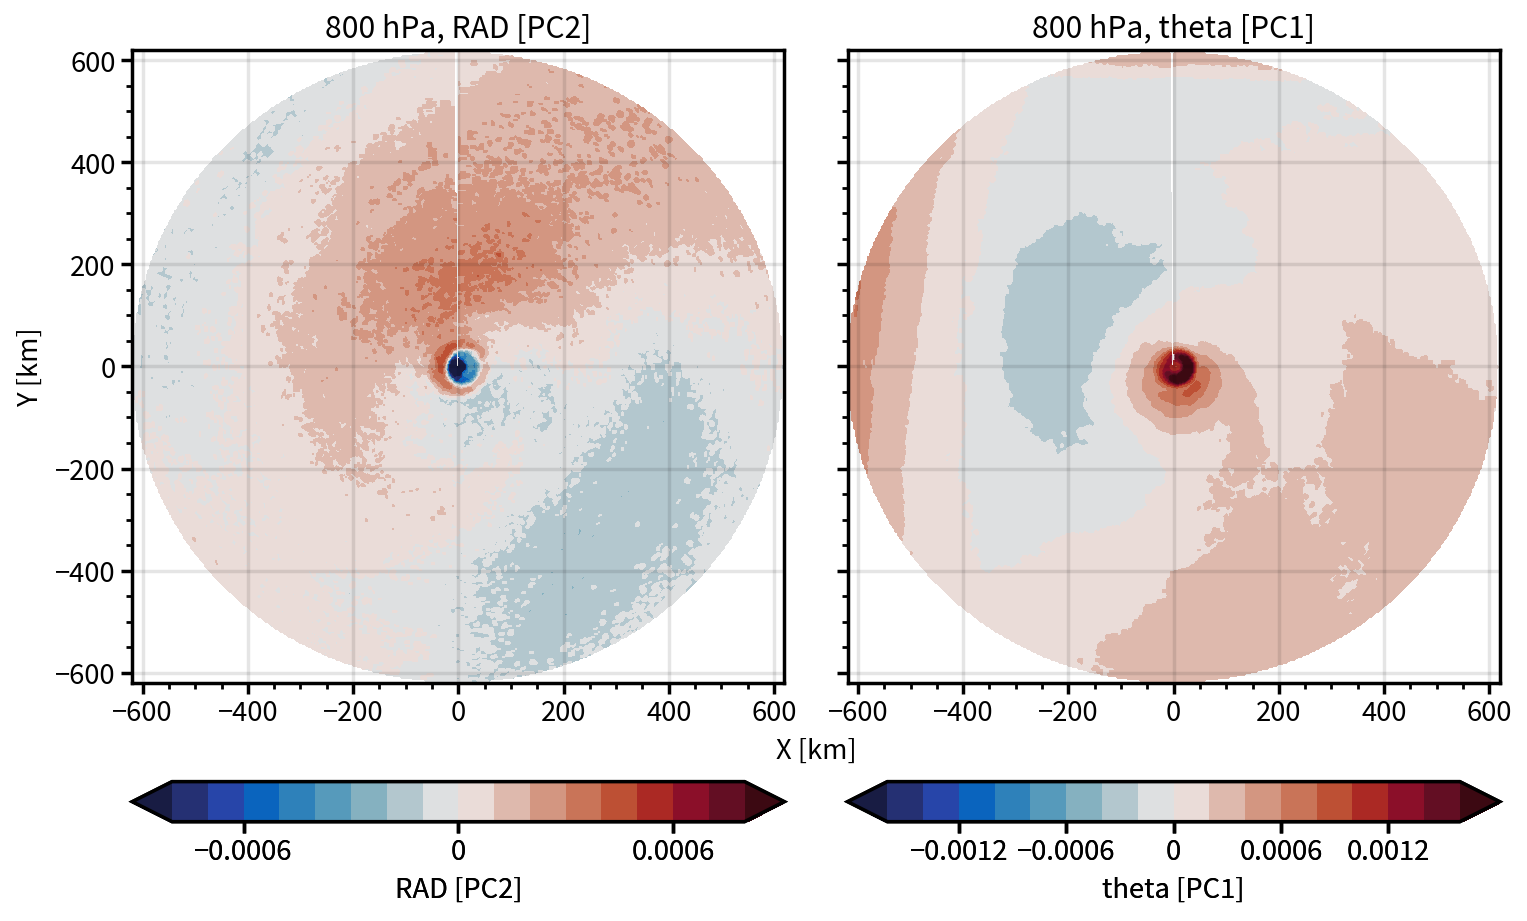

In [151]:
A,A2 = PCAdict['rad'].components_[1,:].reshape(10,360,208)[2,:,:],PCAdict['theta'].components_[0,:].reshape(10,360,208)[2,:,:]
toplot = [A,A2]
ANGLE = read_and_proc.azimuth2angle(np.linspace(0,359,360))
NEWCART_axis = np.concatenate((np.flipud(-np.linspace(0,207,208)*3),np.linspace(0,207,208)*3))
levelss = [np.linspace(-0.0008,0.0008,17),np.linspace(-0.0016,0.0016,17)]
tickss = [0.0006,0.0012]
fig, axs = plot.subplots(ncols=2,nrows=1,axwidth=3.2595,refaspect=1.031)
axs.format(titleabove=True,ylabel='Y [km]', xlabel='X (km)')
typelabel=['RAD [PC2]','theta [PC1]']#['Cloud Longwave [>95%]','Cloud Longwave [<5%]']

for indices in range(2):
    #axs[indices].contourf(np.linspace(-207,207,417)*3,np.linspace(-207,207,417)*3,
    #                      np.ma.masked_equal(np.fliplr(np.flipud((read_and_proc.proc_tocart(PCAdict['rad'].components_[1,:].reshape(10,360,208)[2,:,:],ANGLE,True,False)))),0),\
    #                     cmap='balance',levels=np.linspace(-0.0008,0.0008,17),colorbar='b',colorbar_kw={'format':'simple','ticks':0.0006,'label': 'PC[RAD]_2'},extend='both')
    axs[indices].contourf(np.linspace(-207,207,417)*3,np.linspace(-207,207,417)*3,
                          np.ma.masked_equal(np.fliplr(np.flipud((read_and_proc.proc_tocart(toplot[indices],ANGLE,True,False)))),0),\
                         cmap='balance',levels=levelss[indices],colorbar='b',colorbar_kw={'format':'simple','ticks':0.0006,'label': typelabel[indices]},extend='both')
    #axs[indices].streamplot(np.linspace(-207,207,416)*3,np.linspace(-207,207,416)*3,ut[indices],vt[indices], density=[1.25, 1.25],linewidth=0.5)
    axs[indices].format(ylabel='Y [km]',xlabel='X [km]',title=f'{800} hPa, {typelabel[indices]}')
    #plotting.adjust_spines(axs[indices],['left','bottom'],10)
#plt.savefig('../../figures/0406/new/MLR_dvdtrecon_decompcheck_24hr_800_95_5_vect.png',dpi=300,facecolor=fig.get_facecolor())
plt.show()

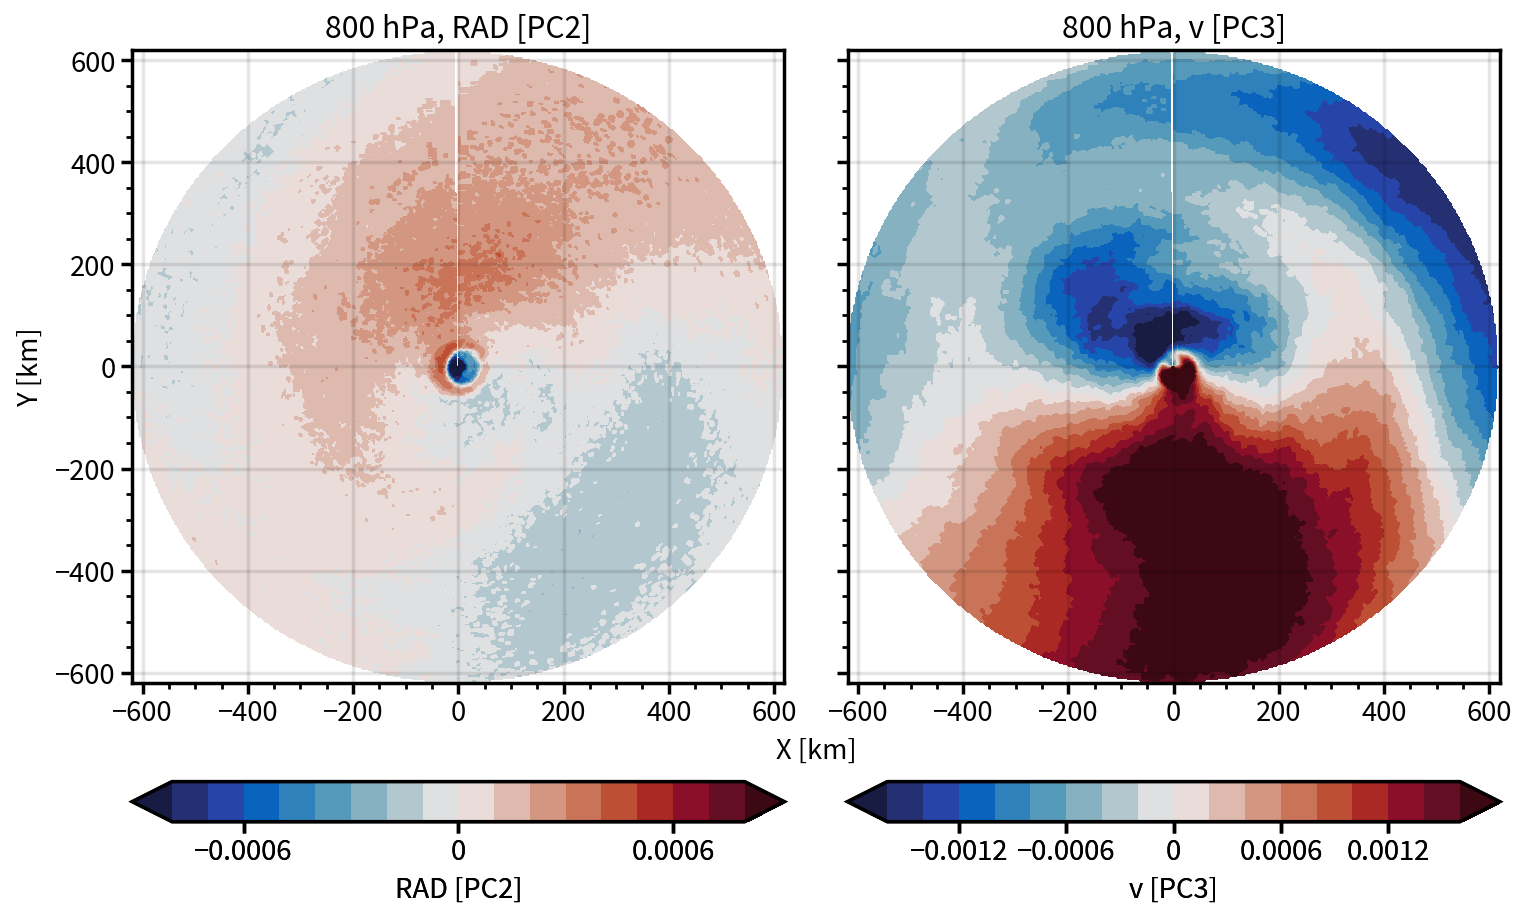

In [152]:
A,A2 = PCAdict['rad'].components_[1,:].reshape(10,360,208)[2,:,:],PCAdict['v'].components_[2,:].reshape(10,360,208)[2,:,:]
toplot = [A,A2]
ANGLE = read_and_proc.azimuth2angle(np.linspace(0,359,360))
NEWCART_axis = np.concatenate((np.flipud(-np.linspace(0,207,208)*3),np.linspace(0,207,208)*3))
levelss = [np.linspace(-0.0008,0.0008,17),np.linspace(-0.0016,0.0016,17)]
tickss = [0.0006,0.0012]
fig, axs = plot.subplots(ncols=2,nrows=1,axwidth=3.2595,refaspect=1.031)
axs.format(titleabove=True,ylabel='Y [km]', xlabel='X (km)')
typelabel=['RAD [PC2]','v [PC3]']#['Cloud Longwave [>95%]','Cloud Longwave [<5%]']

for indices in range(2):
    #axs[indices].contourf(np.linspace(-207,207,417)*3,np.linspace(-207,207,417)*3,
    #                      np.ma.masked_equal(np.fliplr(np.flipud((read_and_proc.proc_tocart(PCAdict['rad'].components_[1,:].reshape(10,360,208)[2,:,:],ANGLE,True,False)))),0),\
    #                     cmap='balance',levels=np.linspace(-0.0008,0.0008,17),colorbar='b',colorbar_kw={'format':'simple','ticks':0.0006,'label': 'PC[RAD]_2'},extend='both')
    axs[indices].contourf(np.linspace(-207,207,417)*3,np.linspace(-207,207,417)*3,
                          np.ma.masked_equal(np.fliplr(np.flipud((read_and_proc.proc_tocart(toplot[indices],ANGLE,True,False)))),0),\
                         cmap='balance',levels=levelss[indices],colorbar='b',colorbar_kw={'format':'simple','ticks':0.0006,'label': typelabel[indices]},extend='both')
    #axs[indices].streamplot(np.linspace(-207,207,416)*3,np.linspace(-207,207,416)*3,ut[indices],vt[indices], density=[1.25, 1.25],linewidth=0.5)
    axs[indices].format(ylabel='Y [km]',xlabel='X [km]',title=f'{800} hPa, {typelabel[indices]}')
    #plotting.adjust_spines(axs[indices],['left','bottom'],10)
#plt.savefig('../../figures/0406/new/MLR_dvdtrecon_decompcheck_24hr_800_95_5_vect.png',dpi=300,facecolor=fig.get_facecolor())
plt.show()

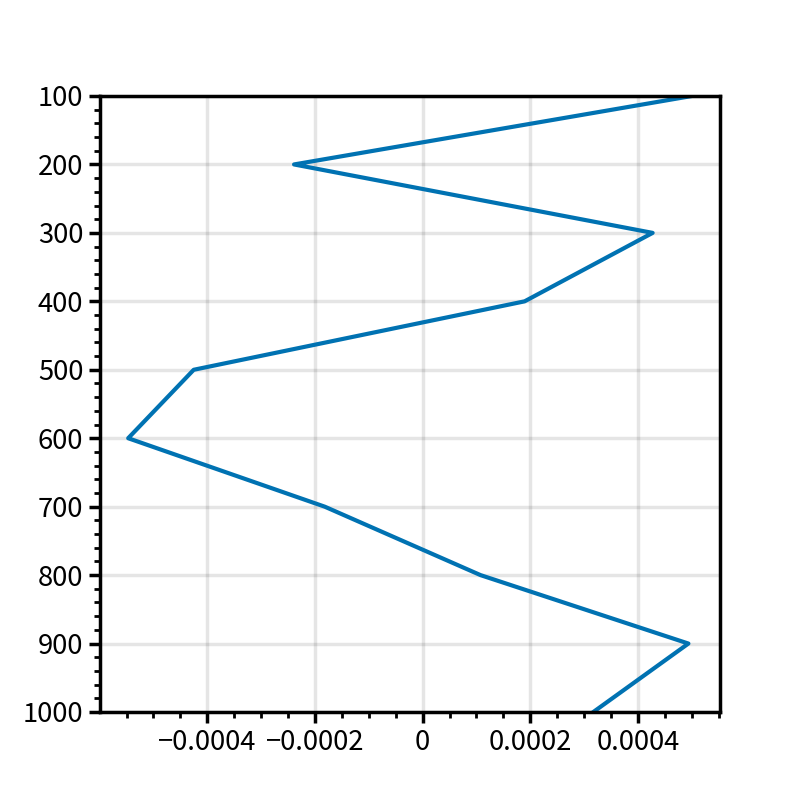

In [160]:
plt.plot(np.nanmean(PCAdict['u'].components_[13,:].reshape(10,360,208),axis=(1,2)),np.linspace(1000,100,10))
plt.ylim(1000,100)
plt.show()

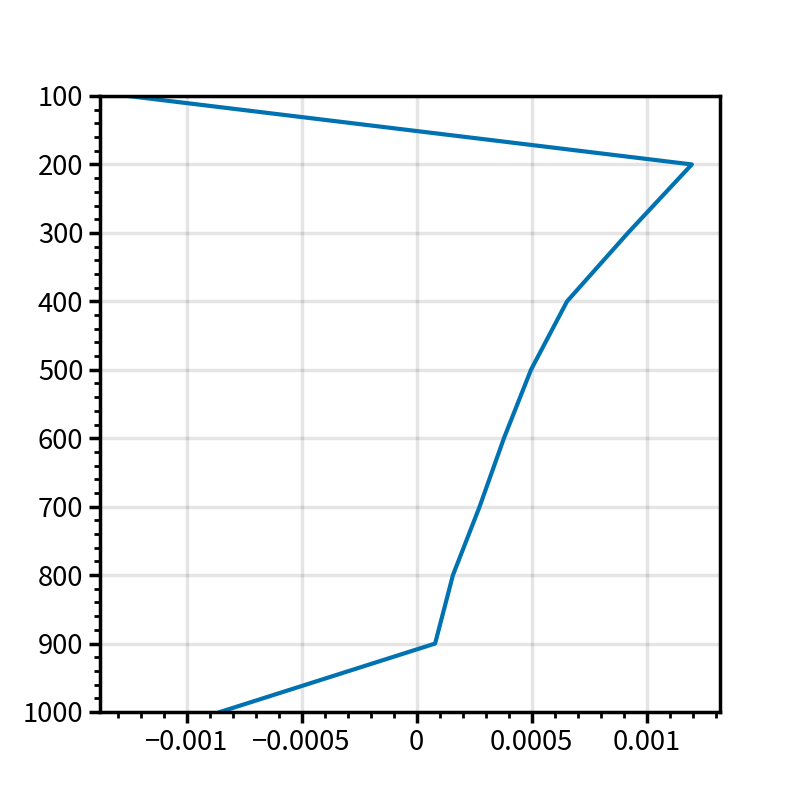

In [163]:
plt.plot(np.nanmean(PCAdict['theta'].components_[0,:].reshape(10,360,208),axis=(1,2)),np.linspace(1000,100,10))
plt.ylim(1000,100)
plt.show()

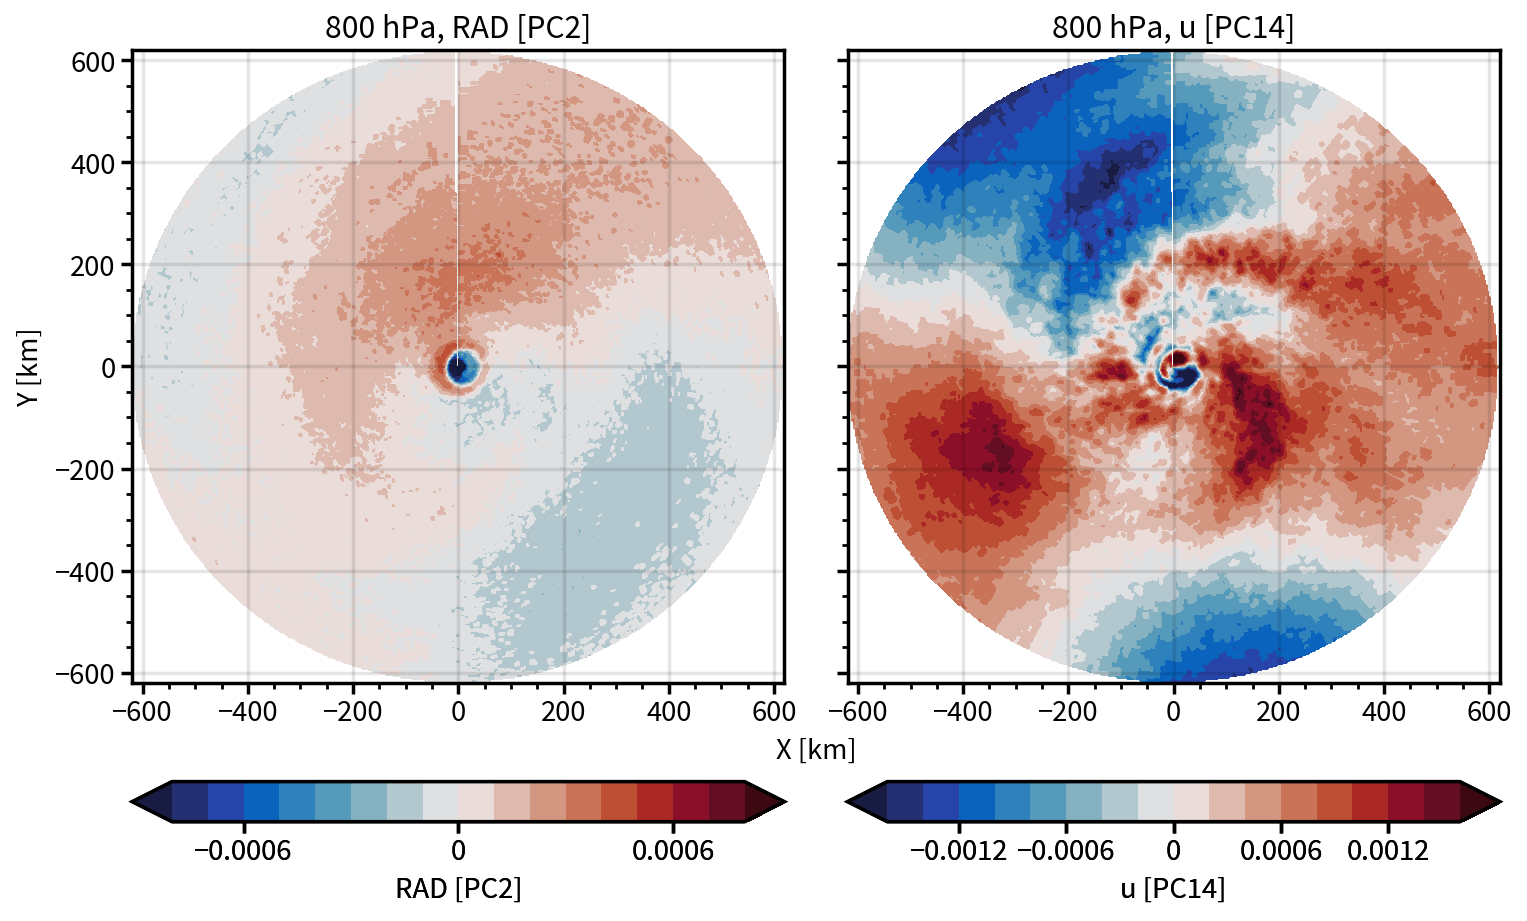

In [153]:
A,A2 = PCAdict['rad'].components_[1,:].reshape(10,360,208)[2,:,:],PCAdict['u'].components_[13,:].reshape(10,360,208)[2,:,:]
toplot = [A,A2]
ANGLE = read_and_proc.azimuth2angle(np.linspace(0,359,360))
NEWCART_axis = np.concatenate((np.flipud(-np.linspace(0,207,208)*3),np.linspace(0,207,208)*3))
levelss = [np.linspace(-0.0008,0.0008,17),np.linspace(-0.0016,0.0016,17)]
tickss = [0.0006,0.0012]
fig, axs = plot.subplots(ncols=2,nrows=1,axwidth=3.2595,refaspect=1.031)
axs.format(titleabove=True,ylabel='Y [km]', xlabel='X (km)')
typelabel=['RAD [PC2]','u [PC14]']#['Cloud Longwave [>95%]','Cloud Longwave [<5%]']

for indices in range(2):
    #axs[indices].contourf(np.linspace(-207,207,417)*3,np.linspace(-207,207,417)*3,
    #                      np.ma.masked_equal(np.fliplr(np.flipud((read_and_proc.proc_tocart(PCAdict['rad'].components_[1,:].reshape(10,360,208)[2,:,:],ANGLE,True,False)))),0),\
    #                     cmap='balance',levels=np.linspace(-0.0008,0.0008,17),colorbar='b',colorbar_kw={'format':'simple','ticks':0.0006,'label': 'PC[RAD]_2'},extend='both')
    axs[indices].contourf(np.linspace(-207,207,417)*3,np.linspace(-207,207,417)*3,
                          np.ma.masked_equal(np.fliplr(np.flipud((read_and_proc.proc_tocart(toplot[indices],ANGLE,True,False)))),0),\
                         cmap='balance',levels=levelss[indices],colorbar='b',colorbar_kw={'format':'simple','ticks':0.0006,'label': typelabel[indices]},extend='both')
    #axs[indices].streamplot(np.linspace(-207,207,416)*3,np.linspace(-207,207,416)*3,ut[indices],vt[indices], density=[1.25, 1.25],linewidth=0.5)
    axs[indices].format(ylabel='Y [km]',xlabel='X [km]',title=f'{800} hPa, {typelabel[indices]}')
    #plotting.adjust_spines(axs[indices],['left','bottom'],10)
#plt.savefig('../../figures/0406/new/MLR_dvdtrecon_decompcheck_24hr_800_95_5_vect.png',dpi=300,facecolor=fig.get_facecolor())
plt.show()

#### Trajectories

In [7]:
def _back_to_exp(timeseries=None,divider=None):
    printout = [timeseries[0:divider[0],:]]
    for i in range(1,19):
        printout.append(timeseries[divider[i-1]:divider[i],:])
    printout.append(timeseries[divider[-2]:,:])
    return printout

def get_surf(index=None):
    surfU_0,surfV_0 = np.asarray(expU[index]).reshape(expU[index].shape[0],10,360,int(expU[index].shape[1]/10/360))[:,0,...],np.asarray(expV[index]).reshape(expV[index].shape[0],10,360,int(expV[index].shape[1]/10/360))[:,0,...]
    #surfU_1,surfV_1 = np.asarray(expU[1]).reshape(expU[1].shape[0],10,360,int(expU[1].shape[1]/10/360))[:,0,...],np.asarray(expV[1]).reshape(expV[1].shape[0],10,360,int(expV[1].shape[1]/10/360))[:,0,...]
    surWSPD_0 = np.max(np.nanmean(np.sqrt(surfU_0**2+surfV_0**2),axis=1),axis=1)
    return surWSPD_0

a = [read_and_proc.depickle(path+'TCGphy/testML/output/haiyan/processed/uvwheat/'+'mem'+str(lime)+suffix)['u'].shape for lime in tqdm(range(1,21))]
divider = np.asarray([aobj[0] for aobj in a]).cumsum()
del a
gc.collect()

#PCRAD = _back_to_exp(RADtimeseries[:,:],divider)
expU,expV = _back_to_exp(haiyan_data['u'],divider),_back_to_exp(haiyan_data['v'],divider)#,_back_to_exp(haiyan_data['qv'],divider)
maxmeanWSURF = [get_surf(index) for index in range(20)]
del haiyan_data['u'],haiyan_data['v']#,haiyan_data['qv']
gc.collect()

  0%|          | 0/20 [00:00<?, ?it/s]

0

In [8]:
ANGLE = read_and_proc.azimuth2angle(np.linspace(0,359,360))
NEWCART_axis = np.concatenate((np.flipud(-np.linspace(0,207,208)*3),np.linspace(0,207,208)*3))

import pandas as pd
inten_rate = [(maxmeanWSURF[i][np.abs(maxmeanWSURF[i]-33).argmin()]-maxmeanWSURF[i][0])/(np.abs(maxmeanWSURF[i]-33).argmin())*(60) for i in range(20)]
ds = pd.DataFrame({'inten_rate':inten_rate})
lowrate_indices = ds[(ds.inten_rate<0.56*60)].index
midrate_indices = list(ds[(ds.inten_rate>0.56*60) & (ds.inten_rate<0.69*60)].index)
highrate_indices = ds[(ds.inten_rate>0.69*60)].index

In [9]:
RADtimeseries = PCAdict['rad'].transform(haiyan_data['rad'].data)[:,0:10]
QVtimeseries = PCAdict['qv'].transform(haiyan_data['qv'].data)[:,0:10]

In [10]:
ds = pd.DataFrame({'inten_rate':inten_rate})

In [11]:
import itertools
def stack_padding(l):
    return np.column_stack((itertools.zip_longest(*l, fillvalue=np.nan)))

PCRAD,PCQV = _back_to_exp(RADtimeseries[:,:],divider),_back_to_exp(QVtimeseries[:,:],divider)
# Intensification Rates
slowinten = stack_padding([maxmeanWSURF[int(obj)] for obj in list(ds[(ds.inten_rate<0.56*60)].index)])
medinten = stack_padding([maxmeanWSURF[int(obj)] for obj in list(ds[(ds.inten_rate>0.56*60) & (ds.inten_rate<0.69*60)].index)])
quickinten = stack_padding([maxmeanWSURF[int(obj)] for obj in list(ds[(ds.inten_rate>0.69*60)].index)])
# PC2
slowPC2 = stack_padding([PCRAD[int(obj)][0:,1] for obj in list(ds[(ds.inten_rate<0.56*60)].index)])
medPC2 = stack_padding([PCRAD[int(obj)][0:,1] for obj in list(ds[(ds.inten_rate>0.56*60) & (ds.inten_rate<0.69*60)].index)])
quickPC2 = stack_padding([PCRAD[int(obj)][0:,1] for obj in list(ds[(ds.inten_rate>0.69*60)].index)])
# PC6
slowPC6 = stack_padding([PCQV[int(obj)][0:,2] for obj in list(ds[(ds.inten_rate<0.56*60)].index)])
medPC6 = stack_padding([PCQV[int(obj)][0:,2] for obj in list(ds[(ds.inten_rate>0.56*60) & (ds.inten_rate<0.69*60)].index)])
quickPC6 = stack_padding([PCQV[int(obj)][0:,2] for obj in list(ds[(ds.inten_rate>0.69*60)].index)])

/tmp/ipykernel_779609/676379422.py:3: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  return np.column_stack((itertools.zip_longest(*l, fillvalue=np.nan)))


In [12]:
meanWSURF_slow,meanPC2_slow,meanPC6_slow = np.nanmean(slowinten,axis=0),np.nanmean(slowPC2,axis=0),np.nanmean(slowPC6,axis=0)
meanWSURF_med,meanPC2_med,meanPC6_med = np.nanmean(medinten,axis=0),np.nanmean(medPC2,axis=0),np.nanmean(medPC6,axis=0)
meanWSURF_quick,meanPC2_quick,meanPC6_quick = np.nanmean(quickinten,axis=0),np.nanmean(quickPC2,axis=0),np.nanmean(quickPC6,axis=0)

/tmp/ipykernel_779609/1922553415.py:18: ProplotWarning: Calling arbitrary axes methods from SubplotGrid was deprecated in v0.8 and will be removed in a future release. Please index the grid or loop over the grid instead.
  axs.grid(alpha=0.3,color='gray',linewidth=1)


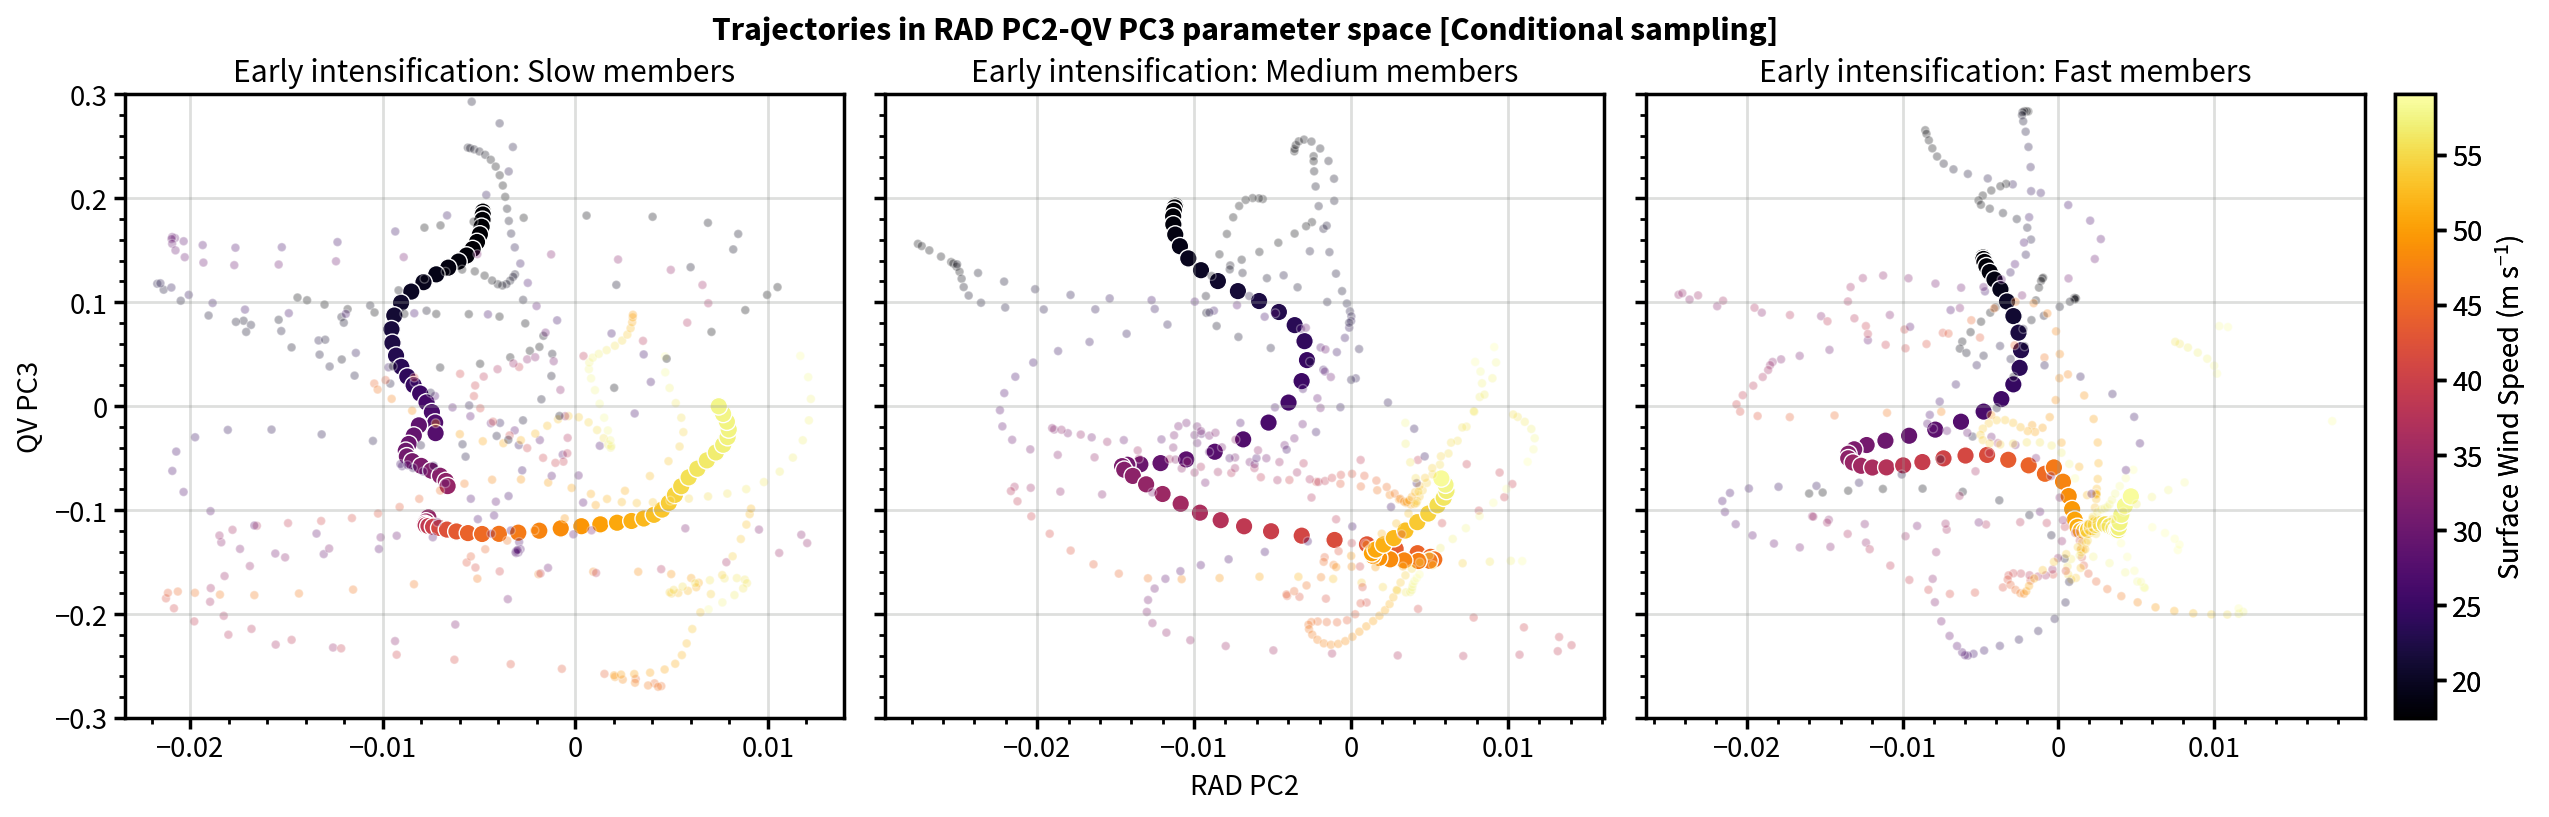

In [20]:
fig,axs = plot.subplots(ncols=3,nrows=1,axwidth=3.595,refaspect=1.1531)
ct0 = axs[0].scatter(np.ma.masked_where(meanWSURF_slow>59,meanPC2_slow),np.ma.masked_where(meanWSURF_slow>59,meanPC6_slow), 
                    s= 40, c = meanWSURF_slow, cmap='inferno',linewidths=0.5, edgecolors='w',vmax=59) #variance:{(pcex[index[i]]*100):.1f}%'
for i in range(len(slowinten)):
    axs[0].scatter(np.ma.masked_where(slowinten[i]>59,slowPC2[i]),np.ma.masked_where(slowinten[i]>59,slowPC6[i]), 
                   s= 10, c = slowinten[i], cmap='inferno',linewidths=0.5, edgecolors='w',vmax=59,alpha=0.3)
#index = 12
ct1 = axs[1].scatter(np.ma.masked_where(meanWSURF_med>59,meanPC2_med),np.ma.masked_where(meanWSURF_med>59,meanPC6_med), 
                    s= 40, c = meanWSURF_med, cmap='inferno',linewidths=0.5, edgecolors='w',vmax=59) #variance:{(pcex[index[i]]*100):.1f}%'
for i in range(len(medinten)):
    axs[1].scatter(np.ma.masked_where(medinten[i]>59,medPC2[i]),np.ma.masked_where(medinten[i]>59,medPC6[i]), 
                   s= 10, c = medinten[i], cmap='inferno',linewidths=0.5, edgecolors='w',vmax=59,alpha=0.3)
ct2 = axs[2].scatter(np.ma.masked_where(meanWSURF_quick>59,meanPC2_quick),np.ma.masked_where(meanWSURF_quick>59,meanPC6_quick), 
                    s= 40, c = meanWSURF_quick, cmap='inferno',linewidths=0.5, edgecolors='w',vmax=59)
for i in range(len(quickinten)):
    axs[2].scatter(np.ma.masked_where(quickinten[i]>59,quickPC2[i]),np.ma.masked_where(quickinten[i]>59,quickPC6[i]), 
                   s= 10, c = quickinten[i], cmap='inferno',linewidths=0.5, edgecolors='w',vmax=59,alpha=0.3)
axs.grid(alpha=0.3,color='gray',linewidth=1)
plt.colorbar(ct0,label='Surface Wind Speed (m s$^{-1}$)')
axs.format(ylabel='QV PC3',xlabel='RAD PC2',ylim=[-0.3,0.3],suptitle=r'Trajectories in RAD PC2-QV PC3 parameter space [Conditional sampling]')
axs[0].format(title=r'Early intensification: Slow members')
axs[1].format(title=r'Early intensification: Medium members')
axs[2].format(title=r'Early intensification: Fast members')
plt.savefig('../../figures/0406/new/0530_fig4.png',dpi=300,facecolor=fig.get_facecolor())
plt.show()

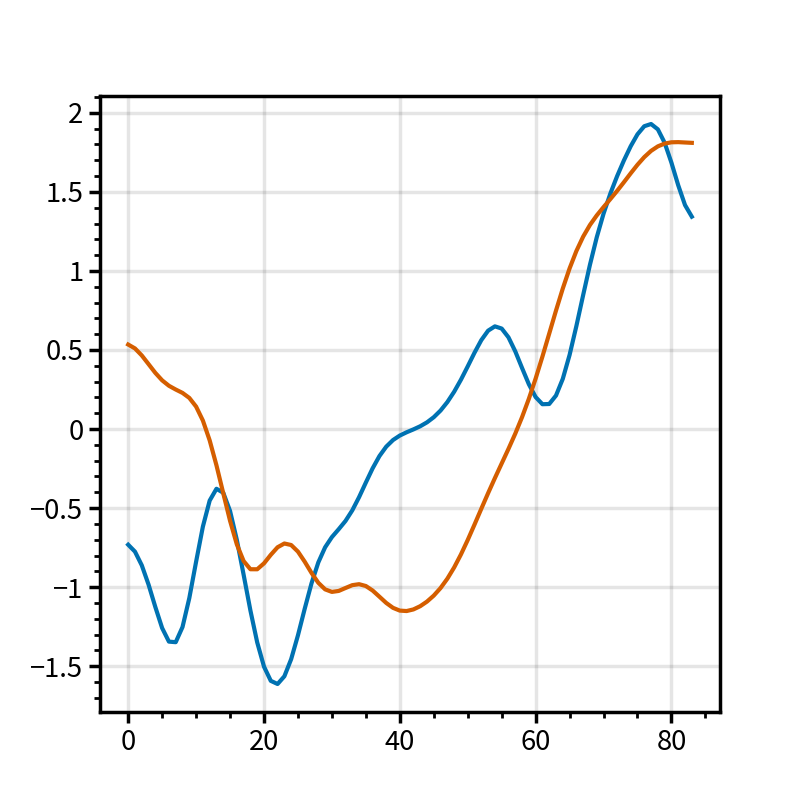

In [27]:
indx=3
plt.plot((medPC2[indx]-np.nanmean(medPC2[indx]))/np.nanstd(medPC2[indx]))
plt.plot((medPC6[indx]-np.nanmean(medPC6[indx]))/np.nanstd(medPC6[indx]))
plt.show()

#### r2

In [ ]:
nummem = [50,38,91,8]
ytrain = [yobj[0] for yobj in yall[expINDEX]]
mlrIN_v,mlrOUT_v = mlr.SimpleIOhandler(LT=lti,auxIN=None).transform(Xtrain[expINDEX]['dtthuvwqv'],ytrain)

loc = [int(obj) for obj in list(np.transpose(np.linspace(269+28,289-1+28-10,10)))]
loopfeature = [np.asarray(loc.copy())]
for i in range(len(test['newfeature'])):
    loopfeature.append(np.append(loopfeature[i],test['newfeature'][i]))
reducedX_train = [np.asarray(mlrIN_v)[:,sorted(loopfeature[i])] for i in range(len(loopfeature))]

r2_train = retrieve_cartesian(PCA_dict=PCAdict,Af_dict=haiyan_data,numcomp=nummem,LT=24,forecastPC=None,target='all',\
                              suffix=suffix).output_r2(FFWmodels=test['model'],reducedX=reducedX_train[1:],realU=train_realUV[expINDEX]['u'],realV=train_realUV[expINDEX]['v'],realW=train_realUV[expINDEX]['w'],
                                                       realTH=train_realUV[expINDEX]['theta'],case='Haiyan',numoutput=5)

In [92]:
def r2_3sets(expINDEX=None,TYPE='train'):
    nummem = [50,38,91,8]
    if TYPE=='test':
        numindex = 2
        realUV = test_realUV
        X = Xtest
    elif TYPE=='valid':
        numindex = 1
        realUV = valid_realUV
        X = Xvalid
    else:
        numindex = 0
        realUV = train_realUV
        X = Xtrain
        
    y = [yobj[numindex] for yobj in yall[expINDEX]]
    mlrIN_v,mlrOUT_v = mlr.SimpleIOhandler(LT=lti,auxIN=None).transform(X[expINDEX]['dtthuvwqv'],y)
    
    loc = [int(obj) for obj in list(np.transpose(np.linspace(269+28,289-1+28-10,10)))]
    loopfeature = [np.asarray(loc.copy())]
    for i in range(len(test[expINDEX]['newfeature'])):
        loopfeature.append(np.append(loopfeature[i],test[expINDEX]['newfeature'][i]))
    
    reducedX_valid = [np.asarray(mlrIN_v)[:,sorted(loopfeature[i])] for i in range(len(loopfeature))]
    r2_valid = retrieve_cartesian(PCA_dict=PCAdict,Af_dict=haiyan_data,numcomp=nummem,LT=24,forecastPC=None,target='all',\
                                  suffix=suffix).output_r2(FFWmodels=test[expINDEX]['model'],reducedX=reducedX_valid[1:],realU=realUV[expINDEX]['u'],realV=realUV[expINDEX]['v'],realW=realUV[expINDEX]['w'],
                                                           realTH=realUV[expINDEX]['theta'],case='Haiyan',numoutput=10)
    return r2_valid

In [94]:
lti=24

r2test = []
for i in tqdm(range(9)):
    r2test.append(r2_3sets(expINDEX=i,TYPE='test'))   

r2valid = []
for i in tqdm(range(9)):
    r2valid.append(r2_3sets(expINDEX=i,TYPE='valid'))
    
r2train = []
for i in tqdm(range(9)):
    r2train.append(r2_3sets(expINDEX=i,TYPE='train'))

  0%|          | 0/9 [00:00<?, ?it/s]

distributed.nanny - WARNING - Worker process still alive after 3 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 3 seconds, killing
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

In [ ]:
np.nanmedian(np.asarray(r2test),axis=0)

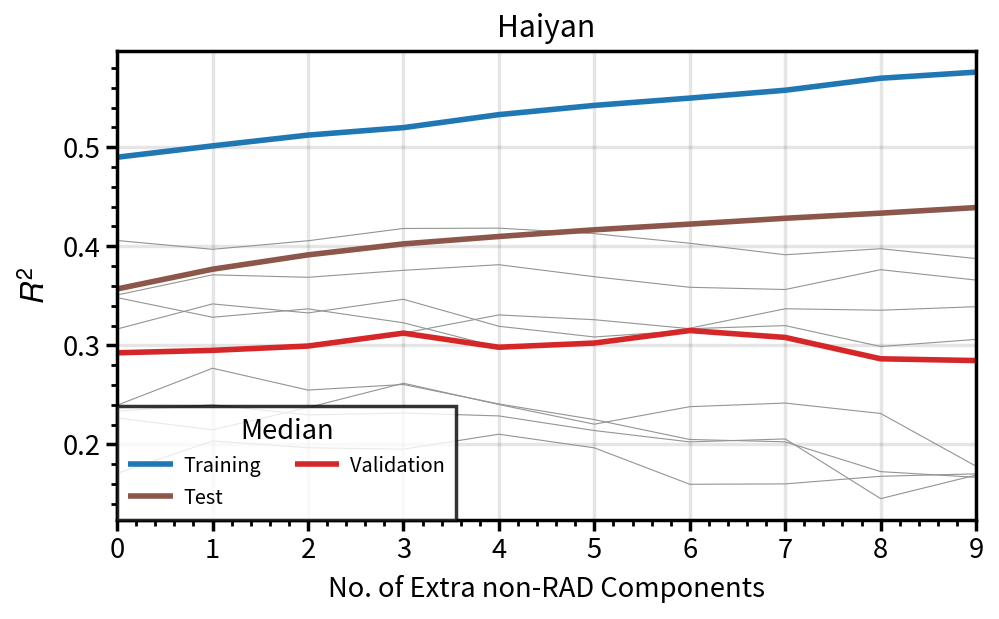

In [90]:
fig,axs = plot.subplots(ncols=1,nrows=1,axwidth=4.295,refaspect=1.831)
for i in range(9):
    axs[0].plot(r2test[i],lw=0.4,c='gray')
axs[0].plot(np.nanmedian(np.asarray(r2train),axis=0),lw=2,c='#1f77b4',label='Training')
axs[0].plot(np.nanmedian(np.asarray(r2test),axis=0),lw=2,c='#d62728',label='Validation')
axs[0].plot(np.nanmedian(np.asarray(r2valid),axis=0),lw=2,c='#8c564b',label='Test')
axs.legend(loc='ll',prop={'size':8},ncols=2,title='Median')
axs[0].format(xlabel=r'No. of Extra non-RAD Components',ylabel=r'$\it{R^2}$',title='Haiyan')
plt.savefig('../../figures/0406/R2_validoptimize.png',dpi=300)
plt.show()

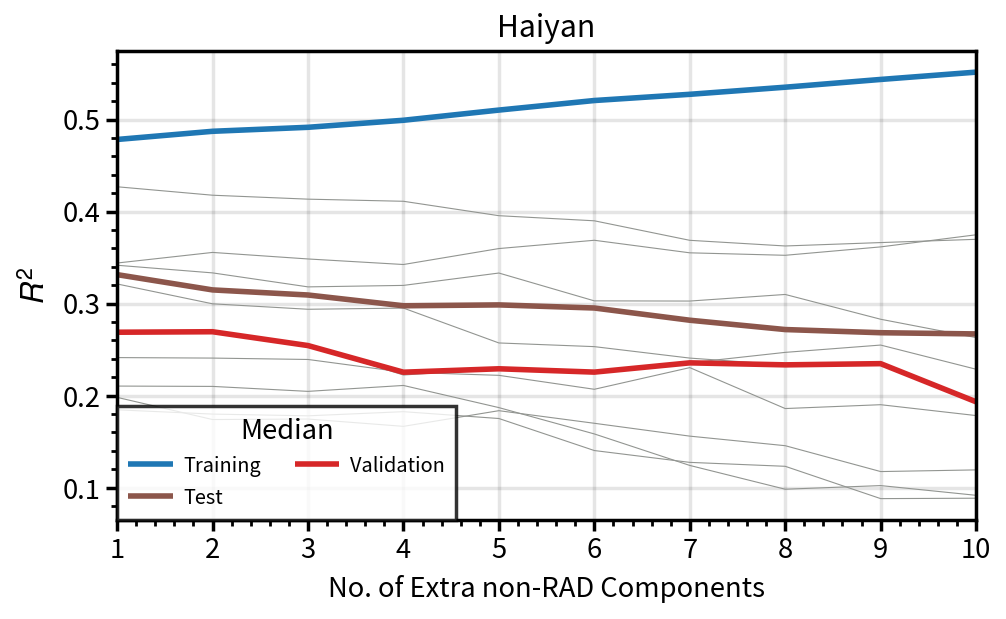

In [98]:
fig,axs = plot.subplots(ncols=1,nrows=1,axwidth=4.295,refaspect=1.831)
for i in range(9):
    axs[0].plot(np.linspace(0,9,10)+1,r2test[i],lw=0.4,c='gray')
axs[0].plot(np.linspace(0,9,10)+1,np.nanmedian(np.asarray(r2train),axis=0),lw=2,c='#1f77b4',label='Training')
axs[0].plot(np.linspace(0,9,10)+1,np.nanmedian(np.asarray(r2test),axis=0),lw=2,c='#d62728',label='Validation')
axs[0].plot(np.linspace(0,9,10)+1,np.nanmedian(np.asarray(r2valid),axis=0),lw=2,c='#8c564b',label='Test')
axs.legend(loc='ll',prop={'size':8},ncols=2,title='Median')
axs[0].format(xlabel=r'No. of Extra non-RAD Components',ylabel=r'$\it{R^2}$',title='Haiyan')
plt.savefig('../../figures/0406/R2_oldoptimize.png',dpi=300)
plt.show()

In [77]:
lti=24
def r2_3sets(expINDEX=None,TYPE='train'):
    nummem = [50,38,91,8]
    if TYPE=='test':
        numindex = 2
        realUV = test_realUV
        X = Xtest
    elif TYPE=='valid':
        numindex = 1
        realUV = valid_realUV
        X = Xvalid
    else:
        numindex = 0
        realUV = train_realUV
        X = Xtrain
        
    y = [yobj[numindex] for yobj in yall[expINDEX]]
    mlrIN_v,mlrOUT_v = mlr.SimpleIOhandler(LT=lti,auxIN=None).transform(X[expINDEX]['dtthuvwqv'],y)
    
    loc = [int(obj) for obj in list(np.transpose(np.linspace(269+28,289-1+28-10,10)))]
    loopfeature = [np.asarray(loc.copy())]
    for i in range(len(test[expINDEX]['newfeature'])):
        loopfeature.append(np.append(loopfeature[i],test[expINDEX]['newfeature'][i]))
    
    reducedX_valid = [np.asarray(mlrIN_v)[:,sorted(loopfeature[i])] for i in range(len(loopfeature))]
    r2_valid = retrieve_cartesian(PCA_dict=PCAdict,Af_dict=haiyan_data,numcomp=nummem,LT=24,forecastPC=None,target='all',\
                                  suffix=suffix).output_r2(FFWmodels=test[expINDEX]['model'],reducedX=reducedX_valid[1:],realU=realUV[expINDEX]['u'],realV=realUV[expINDEX]['v'],realW=realUV[expINDEX]['w'],
                                                           realTH=realUV[expINDEX]['theta'],case='Haiyan',numoutput=10)
    return r2_valid

r2test = []
for i in tqdm(range(9)):
    r2test.append(r2_3sets(expINDEX=i,TYPE='test'))

  0%|          | 0/9 [00:00<?, ?it/s]

In [32]:
lti=24
expINDEX=2
nummem = [50,38,91,8]
yvalid = [yobj[1] for yobj in yall[expINDEX]]
mlrIN_v,mlrOUT_v = mlr.SimpleIOhandler(LT=lti,auxIN=None).transform(Xvalid[expINDEX]['dtthuvwqv'],yvalid)

loc = [int(obj) for obj in list(np.transpose(np.linspace(269+28,289-1+28-7,7)))]#[int(obj) for obj in list(np.transpose(np.linspace(269+28,289-1+28-10,10)))]
loopfeature = [np.asarray(loc.copy())]
for i in range(len(test['newfeature'])):
    loopfeature.append(np.append(loopfeature[i],test['newfeature'][i]))

expINDEX=0    
reducedX_valid = [np.asarray(mlrIN_v)[:,sorted(loopfeature[i])] for i in range(len(loopfeature))]
r2_valid = retrieve_cartesian(PCA_dict=PCAdict,Af_dict=haiyan_data,numcomp=nummem,LT=24,forecastPC=None,target='all',\
                              suffix=suffix).output_r2(FFWmodels=test['model'],reducedX=reducedX_valid[1:],realU=valid_realUV[expINDEX]['u'],realV=valid_realUV[expINDEX]['v'],realW=valid_realUV[expINDEX]['w'],
                                                       realTH=valid_realUV[expINDEX]['theta'],case='Haiyan',numoutput=5)

0.22169619581401653
0.2319008986649754
0.23308732057674209
0.264924824522307
0.272778994704646


In [28]:
lti=24
expINDEX=2
ytest = [yobj[2] for yobj in yall[expINDEX]]
mlrIN_v,mlrOUT_v = mlr.SimpleIOhandler(LT=lti,auxIN=None).transform(Xtest[expINDEX]['dtthuvwqv'],ytest)

loc = [int(obj) for obj in list(np.transpose(np.linspace(269+28,289-1+28-10,10)))]
loopfeature = [np.asarray(loc.copy())]
for i in range(len(test['newfeature'])):
    loopfeature.append(np.append(loopfeature[i],test['newfeature'][i]))
expINDEX=0   
reducedX_test = [np.asarray(mlrIN_v)[:,sorted(loopfeature[i])] for i in range(len(loopfeature))]
r2_test = retrieve_cartesian(PCA_dict=PCAdict,Af_dict=haiyan_data,numcomp=nummem,LT=24,forecastPC=None,target='all',\
                              suffix=suffix).output_r2(FFWmodels=test['model'],reducedX=reducedX_test[1:],realU=test_realUV[expINDEX]['u'],realV=test_realUV[expINDEX]['v'],realW=test_realUV[expINDEX]['w'],
                                                       realTH=test_realUV[expINDEX]['theta'],case='Haiyan',numoutput=5)

0.5061304938018003
0.5097394833255191
0.5126803002249887
0.5283981377536114
0.5477185711331127


In [24]:
lti=24
expINDEX=2
ytest = [yobj[2] for yobj in yall[expINDEX]]
mlrIN_v,mlrOUT_v = mlr.SimpleIOhandler(LT=lti,auxIN=None).transform(Xtest[expINDEX]['dtthuvwqv'],ytest)

loc = [int(obj) for obj in list(np.transpose(np.linspace(269+28,289-1+28-10,10)))]
loopfeature = [np.asarray(loc.copy())]
for i in range(len(test['newfeature'])):
    loopfeature.append(np.append(loopfeature[i],test['newfeature'][i]))
expINDEX=0   
reducedX_test = [np.asarray(mlrIN_v)[:,sorted(loopfeature[i])] for i in range(len(loopfeature))]
r2_test = retrieve_cartesian(PCA_dict=PCAdict,Af_dict=haiyan_data,numcomp=nummem,LT=24,forecastPC=None,target='all',\
                              suffix=suffix).output_r2(FFWmodels=test['model'],reducedX=reducedX_test[1:],realU=test_realUV[expINDEX]['u'],realV=test_realUV[expINDEX]['v'],realW=test_realUV[expINDEX]['w'],
                                                       realTH=test_realUV[expINDEX]['theta'],case='Haiyan',numoutput=5)

0.5101057450534439
0.5152221684568945
0.5158820008706241
0.5420771024013338
0.5465455777725079


In [33]:
lti=24
expINDEX=2
ytest = [yobj[2] for yobj in yall[expINDEX]]
mlrIN_v,mlrOUT_v = mlr.SimpleIOhandler(LT=lti,auxIN=None).transform(Xtest[expINDEX]['dtthuvwqv'],ytest)

loc = [int(obj) for obj in list(np.transpose(np.linspace(269+28,289-1+28-7,7)))]
loopfeature = [np.asarray(loc.copy())]
for i in range(len(test['newfeature'])):
    loopfeature.append(np.append(loopfeature[i],test['newfeature'][i]))
expINDEX=0   
reducedX_test = [np.asarray(mlrIN_v)[:,sorted(loopfeature[i])] for i in range(len(loopfeature))]
r2_test = retrieve_cartesian(PCA_dict=PCAdict,Af_dict=haiyan_data,numcomp=nummem,LT=24,forecastPC=None,target='all',\
                              suffix=suffix).output_r2(FFWmodels=test['model'],reducedX=reducedX_test[1:],realU=test_realUV[expINDEX]['u'],realV=test_realUV[expINDEX]['v'],realW=test_realUV[expINDEX]['w'],
                                                       realTH=test_realUV[expINDEX]['theta'],case='Haiyan',numoutput=5)

0.35375812670573387
0.3994522707939255
0.4236901888384596
0.43575600954983296
0.4452218937624674


In [40]:
len(yvalid)

36